# Tennis ball tracking using Kalman filter

#### Author: Gianvito Losapio

Real data coming from a private club instrumented with a 3D stereoscopic system made of 4 cameras arranged in two stereo pairs, one per each half court.

Data kindly provided by Vito Renò and Ettore Stella, CNR Bari, authors of the papers (source of inspiration for this work):

- V. Renò et.al, "Real-time tracking of a tennis ball by combining 3D data and domain knowledge", 2016 1st International Conference on Technology and Innovation in Sports, Health and Wellbeing (TISHW), Vila Real, 2016, pp. 1-7



### Load data

The reference dataset comprises about 38000 raw frames @ 50 Hz (roughly 280 gigabytes of data for a total of 760 seconds $ \simeq $ 13 mins) that represent a friendly match. 3D information of the ball were extracted through image processing techniques and through the application of projective transformations.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from utils import plot_track

ball = np.genfromtxt('data/ball.csv', delimiter=';')

In [2]:
import pandas as pd

ball_df = pd.read_csv('data/ball_df.csv', sep=';')

ball_df.head()

,Frame_ID,x,y,z,Camera_ID
0,47577,-1.320.306,11.237.575,0.406777,1
1,47578,-1.316.668,11.223.627,0.35662,1
2,47586,-116.686,11.814.217,0.361157,1
3,47587,-1.165.048,11.811.905,0.419038,1
4,47588,-1.165.751,11.815.716,0.47329,1


The unit measures for $(x,y,z)$ is meter.

In [3]:
print("Dataset dimension: {} x {}".format(ball_df.shape[0], ball_df.shape[1]))
print("Sampling frequency: 50 Hz --> deltat = {} seconds".format(1/50))

Dataset dimension: 8321 x 5
Sampling frequency: 50 Hz --> deltat = 0.02 seconds


The center of the reference system is exactly in the middle of the court so that the X-Y plane matches the ground plane (with X axis being the shortest side) and coordinate z represents the ball height. The black marker represent the position of the 4 cameras.

<img src="data/realdata.png" style="width:1100px;height:600px;"></img>

Ground truth: 893 3D points manually annotated

In [4]:
ground_truth = np.genfromtxt('data/ground_truth.csv', delimiter=';')
# print("Ground truth dimension: {} x {}".format(ground_truth.shape[0], ground_truth.shape[1]))

Take the frames which are in common between the ground truth and our real data

In [5]:
frames = ground_truth[:,0]
intersect, frames_idx, ball_idx = np.intersect1d(frames, ball[:,0], return_indices=True)

print("Number of matching common frames: {}\n".format(frames_idx.shape[0]))

# Filter
ball_final = ball[ball_idx,:]
gt_final = ground_truth[frames_idx,:]

Number of matching common frames: 583



Visualize the resulting data

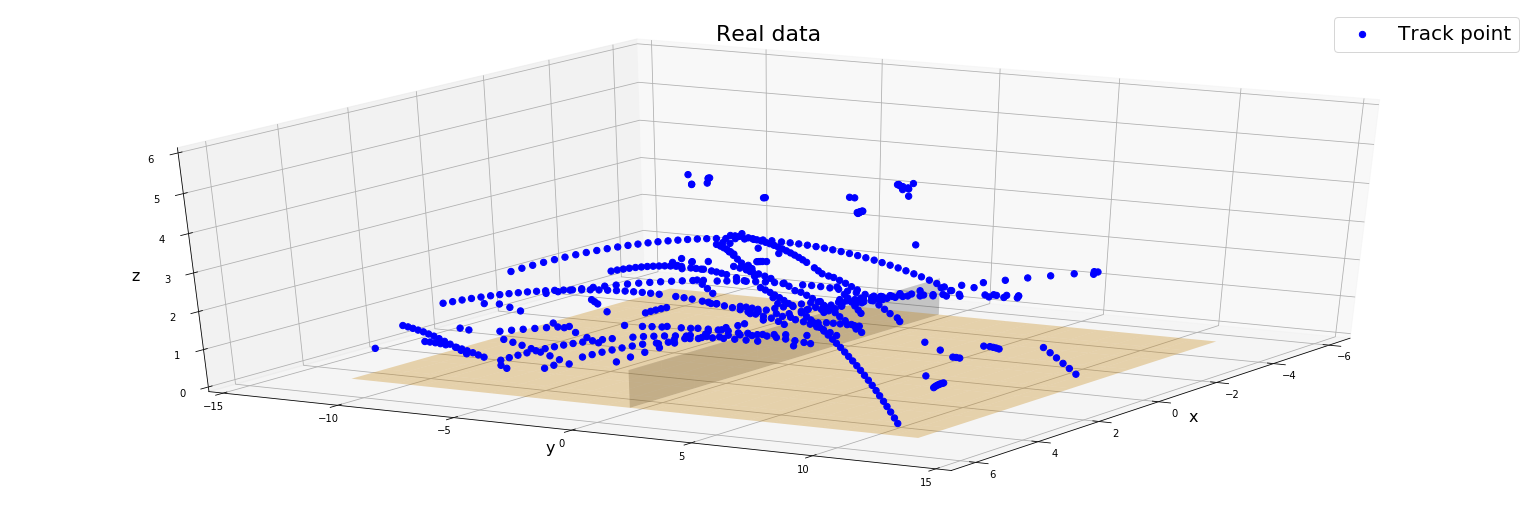

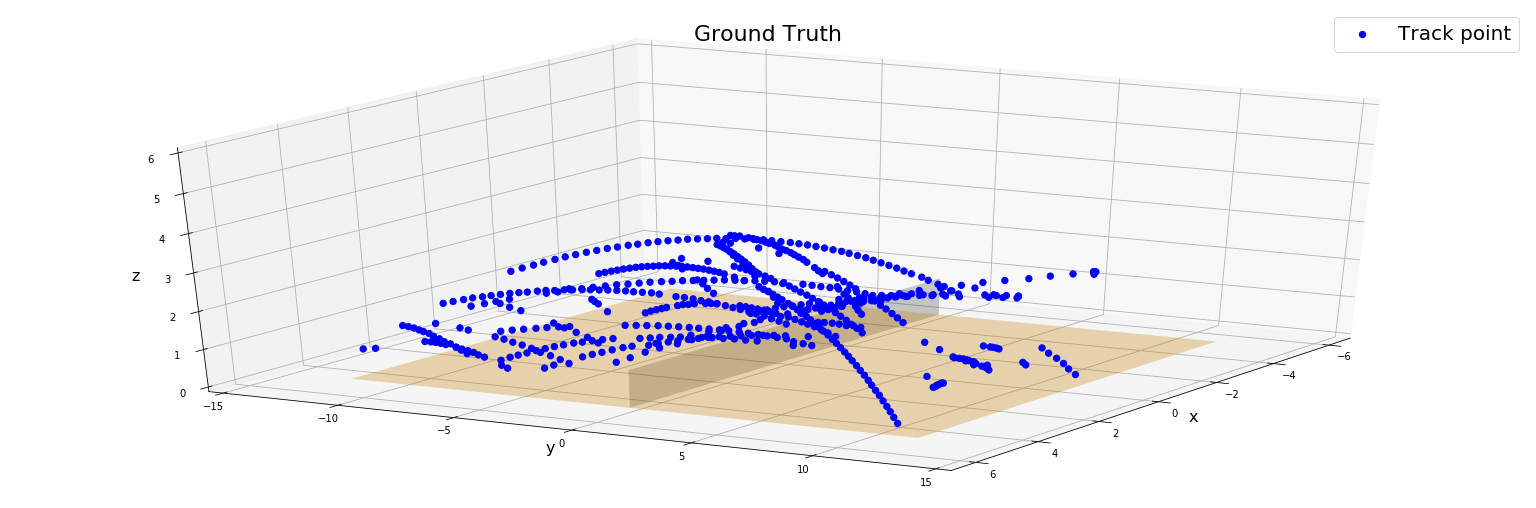

In [6]:
plot_track(ball_final, title='Real data')
plot_track(gt_final, title="Ground Truth")

### Tracklets

Define tracklets (pieces of valid trajectories) as suggested in the paper. A point is represented by

$$
P_i = (f_i, x_i, y_i, z_i)
$$

where $f_i$ is the frame number and $(x_i, y_i, z_i)$ is the position in the space.

A point $P_j$ belongs to the same tracklet of $P_i$ iff:

- $\Phi_{ji} = |f_j - f_i| < 10 $ (temporal coherency)

- $\delta_{ji} = \sqrt{(x_j - x_i)^2 + (y_j - y_i)^2 + (z_j - z_i)^2} < 0.7 \,(2-2^{1-\Phi_{ji}}) $ (spatial coherency)

Function and thresholds are proposed in the paper (experimentally chosen as they depend
on both hardware setup i.e. cameras temporal resolution
and players’ skills i.e. ball speed during the gameplay).

<img src="data/tracklet.png" style="width:400px;height:200px;"></img>

In [7]:
def temporal_distance(start_frame, next_frame):
    """
    Temporal distance between 2 frames

    """
    return np.abs(start_frame - next_frame)

def spatial_distance(start_frame_xyz, next_frame_xyz):
    """
    Euclidean distance between 2 points
    
    """       
    return np.sqrt(np.sum((start_frame_xyz - next_frame_xyz)**2))

In [8]:
# Initialize the column tracklets ID with zeros
dim = ball_final.shape[0]
tracklets = np.concatenate((ball_final, np.zeros(dim)[:,None]), axis=1)


# Init var
start_frame_idx = 0 
next_frame_idx = 1

tracklets_ID = 0

# Parameters taken from the paper
tau_time = 10
tau_space = 0.7

# Start forward scanning
while next_frame_idx < dim:
    
    phi = temporal_distance(tracklets[start_frame_idx,0],tracklets[next_frame_idx,0])
    
    if phi < tau_time:
    
        delta = spatial_distance(tracklets[start_frame_idx,1:4],tracklets[next_frame_idx,1:4])
    
        space_thresh = tau_space * (2 - 2**(1-phi))
    
        if delta < space_thresh:
        
            # next point belongs to the same tracklet
            # (both conditions are verified)
            tracklets[next_frame_idx,5] = tracklets_ID
        
    # If one of the two condition is not verified
    # assign the next frame a new tracklet_ID
        else:
        
            tracklets_ID += 1
            tracklets[next_frame_idx,5] = tracklets_ID
        
    else:
        
        tracklets_ID += 1
        tracklets[next_frame_idx,5] = tracklets_ID
        
    start_frame_idx += 1
    next_frame_idx += 1

In [9]:
print(tracklets.shape)
print(tracklets[:,5])

(583, 6)
[  0.   1.   2.   3.   4.   5.   5.   5.   5.   5.   5.   5.   5.   5.
   5.   5.   5.   6.   7.   7.   7.   7.   7.   7.   7.   7.   7.   8.
   8.   8.   8.   8.   8.   8.   8.   9.  10.  10.  11.  11.  12.  13.
  13.  14.  14.  14.  14.  14.  14.  14.  14.  14.  14.  14.  14.  14.
  14.  14.  14.  14.  14.  14.  14.  14.  14.  14.  14.  14.  14.  14.
  14.  14.  14.  14.  14.  15.  15.  16.  17.  18.  19.  20.  21.  22.
  23.  23.  24.  25.  26.  27.  27.  27.  27.  27.  27.  27.  27.  27.
  28.  28.  28.  28.  28.  28.  28.  28.  29.  30.  30.  30.  30.  30.
  30.  30.  30.  30.  30.  30.  30.  30.  30.  30.  30.  30.  30.  30.
  30.  30.  30.  31.  31.  31.  32.  32.  32.  32.  32.  32.  32.  32.
  32.  32.  33.  34.  34.  34.  34.  34.  34.  34.  34.  35.  35.  36.
  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47.  48.  49.  50.
  50.  50.  50.  50.  51.  51.  51.  52.  52.  52.  52.  52.  52.  52.
  52.  52.  52.  52.  52.  52.  52.  52.  52.  52.  52.  52.  52.  5

## Recall points

Recall further coherent points with respect to the tracklets founds (points near to the ground plane, exluded a priori from the data and stored in a different file)

<img src="data/removed.png" style="width:400px;height:180px;"></img>
<img src="data/recalled.png" style="width:400px;height:220px;"></img>

In [10]:
ball_nf = np.genfromtxt('data/ball_nf.csv', delimiter=';')

track_IDs = np.unique(tracklets[:,5])

tau_time = 10
tau_space = 0.7

track_augmented = np.array([]).reshape(0,6)

for tr_ID in track_IDs:
    
    current_track = tracklets[tracklets[:,5] == tr_ID]
    
    # define temporal coherent interval we are looking for
    min_frame = current_track[0,0] - tau_time + 1
    max_frame = current_track[-1,0] + tau_time - 1
    
    frame_interval = np.arange(min_frame,max_frame)
    
    # find temporal holes in the current track
    holes = np.setdiff1d(frame_interval,current_track[:,0])
    
    # find corresponding recallable points (if any)
    a, b, idx = np.intersect1d(holes,ball_nf[:,0], return_indices=True)
    
    # Init vars
    merged_track = current_track
    dim = merged_track.shape[0]

    # if there is at least 1 recallable temporarily coherent point
    if idx.size != 0:
    
        # use idx to access recallable points
        recallable_pts = ball_nf[idx,:]
        
        # merge recalled points to current tracklet
        # (need to add track_ID column before merging)
        recallable_pts = np.concatenate((recallable_pts, tr_ID*np.ones(idx.size)[:,None]), axis = 1)
        merged_track = np.concatenate((current_track, recallable_pts))
        
        # sort in ascending order wrt the frame ID
        a = np.argsort(merged_track[:,0])
        merged_track = merged_track[a,:]
        
        # Find coherent spatial points
        
        # mask will contain the index of points to be excluded (not spatially coherent
        # wrt the initial tracklet)
        mask = np.array([])
        
        a, idx, b  = np.intersect1d(merged_track[:,0],current_track[:,0], return_indices=True)
       
        # Backward scan
        start_frame_idx = idx[0] 
        next_frame_idx = start_frame_idx - 1

        
        while next_frame_idx >= 0:

            phi = temporal_distance(merged_track[start_frame_idx,0],merged_track[next_frame_idx,0])

            delta = spatial_distance(merged_track[start_frame_idx,1:4],merged_track[next_frame_idx,1:4])

            space_thresh = tau_space * (2 - 2**(1-phi))

            if delta >= space_thresh:

                mask = np.concatenate((mask, np.arange(next_frame_idx + 1)), axis = 0).astype('int')
                break

            start_frame_idx -= 1
            next_frame_idx -= 1

            
        # Forward scan
        dim = merged_track.shape[0]
    
        start_frame_idx = idx[-1] 
        next_frame_idx = start_frame_idx + 1

        
        while next_frame_idx < dim:

            phi = temporal_distance(merged_track[start_frame_idx,0],merged_track[next_frame_idx,0])

            delta = spatial_distance(merged_track[start_frame_idx,1:4],merged_track[next_frame_idx,1:4])

            space_thresh = tau_space * (2 - 2**(1-phi))

            if delta >= space_thresh:

                mask = np.concatenate((mask, np.arange(next_frame_idx, dim)), axis = 0).astype('int')
                break

            start_frame_idx += 1
            next_frame_idx += 1
            
        
        # Central points are not taken into account!(only backward and forward scan)
        
        if mask.size != 0:
            
            idx = np.arange(dim)
            mask = np.setdiff1d(idx, mask)
            merged_track = merged_track[mask,:]

            
            
    track_augmented = np.concatenate((track_augmented, merged_track), axis = 0)
        

In [11]:
print(track_augmented.shape)
print(track_augmented[:,5])

(666, 6)
[  0.   1.   2.   3.   4.   5.   5.   5.   5.   5.   5.   5.   5.   5.
   5.   5.   5.   6.   7.   7.   7.   7.   7.   7.   7.   7.   7.   7.
   7.   7.   7.   7.   7.   7.   7.   8.   8.   8.   8.   8.   8.   8.
   8.   8.   8.   8.   8.   8.   8.   8.   8.   8.   9.  10.  10.  11.
  11.  12.  13.  13.  14.  14.  14.  14.  14.  14.  14.  14.  14.  14.
  14.  14.  14.  14.  14.  14.  14.  14.  14.  14.  14.  14.  14.  14.
  14.  14.  14.  14.  14.  14.  14.  14.  14.  15.  15.  16.  17.  18.
  19.  20.  21.  22.  23.  23.  24.  25.  26.  27.  27.  27.  27.  27.
  27.  27.  27.  27.  27.  28.  28.  28.  28.  28.  28.  28.  28.  29.
  30.  30.  30.  30.  30.  30.  30.  30.  30.  30.  30.  30.  30.  30.
  30.  30.  30.  30.  30.  30.  30.  30.  31.  31.  31.  32.  32.  32.
  32.  32.  32.  32.  32.  32.  32.  33.  34.  34.  34.  34.  34.  34.
  34.  34.  35.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.
  46.  47.  48.  49.  49.  49.  49.  49.  49.  49.  49.  50.  50.  5

Keep tracklets with at least 3 points

In [12]:
(unique, index, counts) = np.unique(track_augmented[:,5], return_index =True, return_counts=True)

tot = track_augmented.shape[0]

mask = np.zeros(tot)
mask = mask > 0

for i, count in enumerate(counts):
    
    if count >= 3:
        
        mask[index[i]:index[i] + count] = True

track_final = track_augmented[mask]

# Tot tracklets
(unique, index, counts) = np.unique(track_final[:,5], return_index =True, return_counts=True)
print("Total tracklets found with at least 3 points: {}\n".format(unique.shape[0]))

# Print pairs (tracklet_ID, number of corresponding points)
pairs = np.concatenate((unique[:,None],counts[:,None]), axis = 1)
print(pairs)

Total tracklets found with at least 3 points: 41

[[  5.  12.]
 [  7.  17.]
 [  8.  17.]
 [ 14.  33.]
 [ 27.  10.]
 [ 28.   8.]
 [ 30.  22.]
 [ 31.   3.]
 [ 32.  10.]
 [ 34.   8.]
 [ 49.   8.]
 [ 50.   8.]
 [ 51.   3.]
 [ 52.  50.]
 [ 53.  11.]
 [ 60.   6.]
 [ 61.   4.]
 [ 64.  30.]
 [ 65.   7.]
 [ 66.   8.]
 [ 68.  34.]
 [ 69.  25.]
 [ 70.  37.]
 [ 75.   3.]
 [ 76.   7.]
 [ 77.   4.]
 [ 80.   3.]
 [ 81.   8.]
 [ 84.  12.]
 [ 86.   5.]
 [ 89.  27.]
 [ 90.  18.]
 [ 93.   7.]
 [ 94.  20.]
 [ 95.  15.]
 [ 97.  12.]
 [ 99.   5.]
 [100.   5.]
 [101.   5.]
 [104.  31.]
 [106.  25.]]


#### Visualize some resulting tracklets

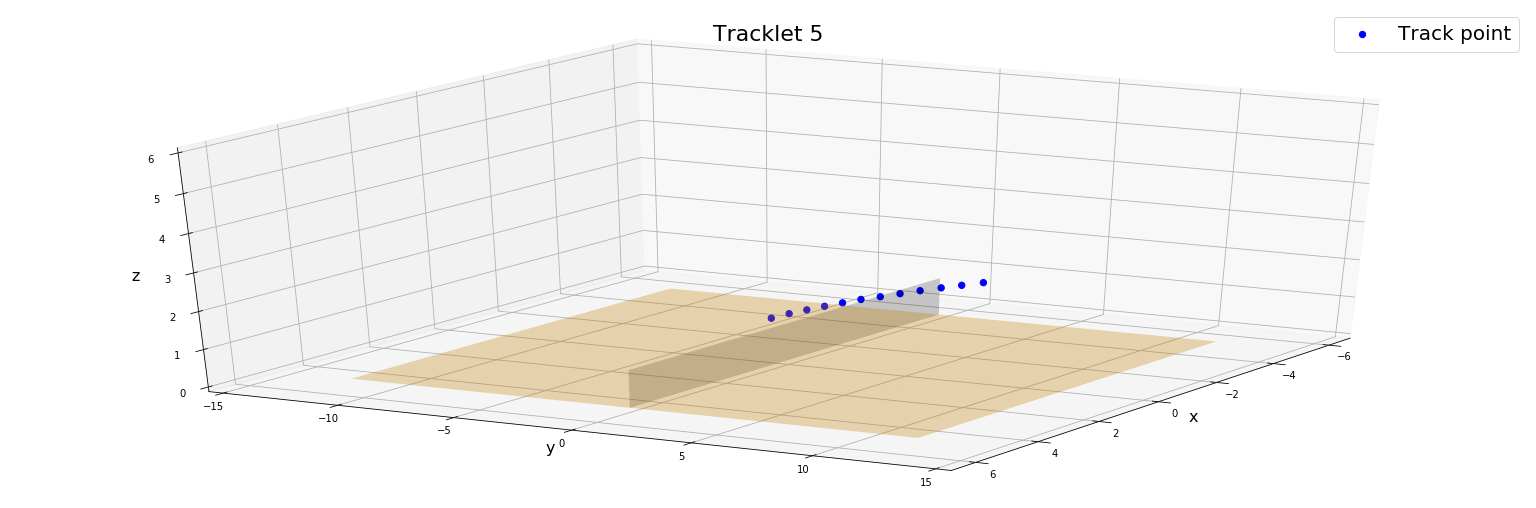

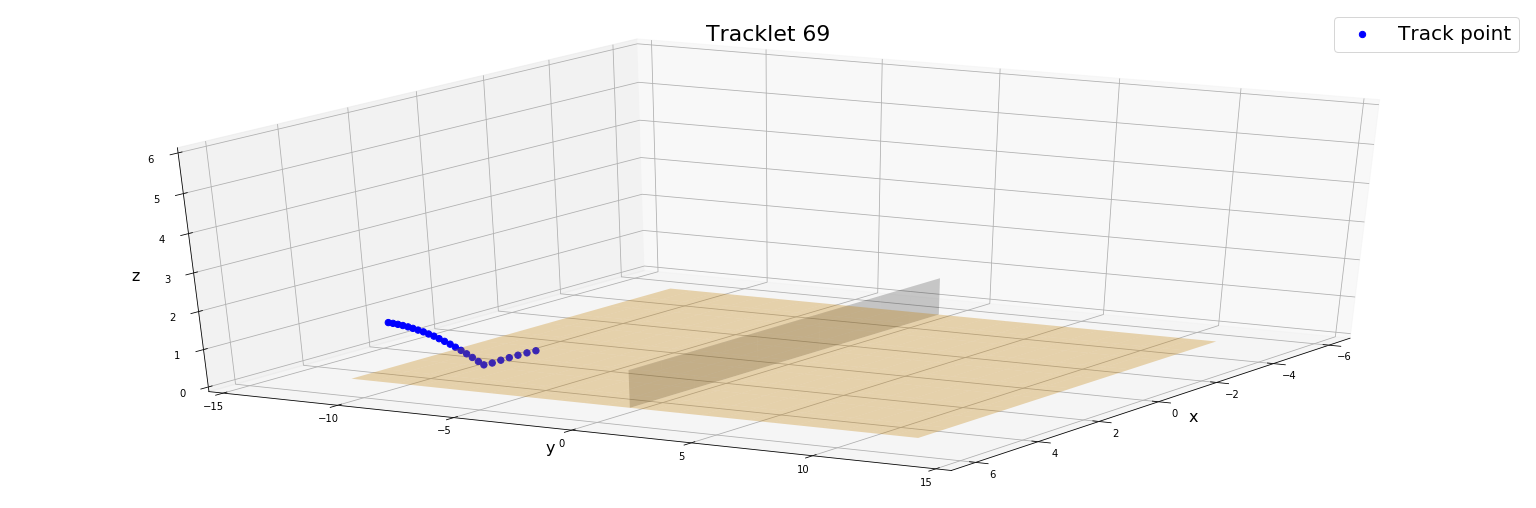

In [13]:
track_ID = 5
track = track_final[track_final[:,5] == track_ID]
plot_track(track,title='Tracklet {}'.format(track_ID))

track_ID = 69
track = track_final[track_final[:,5] == track_ID]
plot_track(track,title='Tracklet {}'.format(track_ID))

### Sub-tracklets

Tracklets can be now split in sub-tracklets to deal with bounces on the ground and changes of direction. Note that this is necessary to deal with the simple physics model later used in the Kalman filter. 

- Bounces can be easily recognized looking at the z coordinate and searching for local minima around zero

- Strokes can be found exploiting the changes in the sign of the velocity along the Y-axis



Subtracklets caused by bounces are identified first. Then, further splitting is considered for each of them looking for strokes.

<img src="data/subtracklet.png" style="width:400px;height:220px;"></img>

In [14]:
def strokes_subtrack(tracklet, start_index, end_index, counter_ID):
    """
    Find subtracklets according to strokes
    
    """
    current_subtrack = tracklet[start_index:end_index, :]
    dim = current_subtrack.shape[0]
    
    # Compute sign of derivative (simple difference)
    y_der_sign = np.sign(np.diff(current_subtrack[:,2]))
    
    # Find sign changes
    signchange = ((np.roll(y_der_sign, 1) - y_der_sign) != 0).astype(int)
    signchange[0] = 0
    
    # Find idx of sign changes
    signchange_idx = np.argwhere(signchange)

    # If at least 1 stroke has been identified
    if signchange_idx.size != 0:
        
        # the index should be increased by 1 because
        # np.diff reduces the size of 1
        y_change = signchange_idx[0][0] + 1

        # Split according to the stroke
        left = current_subtrack[:y_change, :]
        right = current_subtrack[y_change:, :]

        
        # If the splits contain at least 3 points
        if left.shape[0] >= 3:
            left[:,6] = counter_ID
            counter_ID += 1
            
        if right.shape[0] >= 3:
            right[:,6] = counter_ID
            counter_ID += 1

    else:       
        current_subtrack[:,6] = counter_ID
        counter_ID += 1
    
    return tracklet, counter_ID

In [15]:
def find_subtrack(tracklet, start_index, end_index, counter_ID):
    """
    Find subtracklets. Recursive
    
    """
    
    # z threshold for bounces (manually selected)
    threshold = 0.04
    
    current_subtrack = tracklet[start_index:end_index, :]
    dim = current_subtrack.shape[0]
    
    bounce = False
    
    if dim >= 3:
    
        z_min = np.argmin(current_subtrack[:,3])
        
        if current_subtrack[z_min,3] < threshold:
        
            if z_min != dim-1: 

                if z_min >= 3:
        
                    tracklet, counter_ID = find_subtrack(tracklet, start_index, z_min, counter_ID)
                    bounce = True
                    
            if z_min != 0:
            
                if dim - z_min >= 3:

                    tracklet, counter_ID = find_subtrack(tracklet, z_min, dim, counter_ID)
                    bounce = True
                    
        if bounce is False:  
            
            tracklet, counter_ID = strokes_subtrack(tracklet, start_index, end_index, counter_ID)
    
    return tracklet, counter_ID

In [16]:
# Init a new column with -1 for subtracklet IDs, now last index is 6
tot = track_final.shape[0]
subtracklets = np.concatenate((track_final, -1*np.ones(tot)[:,None]), axis=1)

IDs = np.unique(subtracklets[:,5])

subtracklets_final = np.array([]).reshape(0,7)

for track_ID in IDs:
    
    current_track = subtracklets[subtracklets[:,5] == track_ID]
    
    # Find subtracks
    start_index = 0
    end_index = current_track.shape[0]
    counter_subtr_ID = 0
    
    current_track, counter_ID = find_subtrack(current_track, start_index, end_index, counter_subtr_ID)
    
    # Append
    subtracklets_final = np.concatenate((subtracklets_final, current_track), axis = 0)

# Remove points which are not valid subtracklets (< 3 points, still having -1 as subtracklet ID)
subtracklets_final = subtracklets_final[subtracklets_final[:,6] != -1]
print("Total points left: {}".format(subtracklets_final.shape[0]))

Total points left: 574


- Final number of subtracklets: 45

Click on the dots to have an overview of final subtracklets.

In [17]:
IDs = np.unique(subtracklets_final[:,5])

final_list = np.array([]).reshape(0,3)

for track_ID in IDs:
    
    current_track = subtracklets_final[subtracklets_final[:,5] == track_ID]
    
    dim = current_track.shape[0]
    
    (sub_IDs, index, counts) = np.unique(current_track[:,6], return_index=True, return_counts=True)
    
    tot_subtrack = sub_IDs.size
    
    track_ID_array = track_ID*np.ones(tot_subtrack) 
    current_list = np.concatenate((track_ID_array[:,None], sub_IDs[:,None]), axis=1)
    current_list = np.concatenate((current_list, counts[:,None]), axis=1)

    final_list = np.concatenate((final_list, current_list), axis = 0)

print('Final number of subtracklets: {}\n'.format(final_list.shape[0]))
print('Format: [Tracklet_ID, Subtracklet_ID, number of points]\n')
print(final_list)

Final number of subtracklets: 45

Format: [Tracklet_ID, Subtracklet_ID, number of points]

[[  5.   0.  12.]
 [  7.   0.  10.]
 [  7.   1.   7.]
 [  8.   0.   7.]
 [  8.   1.  10.]
 [ 14.   0.  33.]
 [ 27.   0.  10.]
 [ 28.   0.   7.]
 [ 30.   0.  22.]
 [ 31.   0.   3.]
 [ 32.   0.   8.]
 [ 34.   0.   8.]
 [ 49.   0.   8.]
 [ 50.   0.   8.]
 [ 51.   0.   3.]
 [ 52.   0.  50.]
 [ 53.   0.  11.]
 [ 60.   0.   6.]
 [ 61.   0.   4.]
 [ 64.   0.   9.]
 [ 64.   1.  21.]
 [ 65.   0.   7.]
 [ 66.   0.   7.]
 [ 68.   0.  27.]
 [ 68.   1.   7.]
 [ 69.   0.   6.]
 [ 69.   1.  19.]
 [ 70.   0.  37.]
 [ 75.   0.   3.]
 [ 76.   0.   7.]
 [ 77.   0.   4.]
 [ 81.   0.   6.]
 [ 84.   0.  12.]
 [ 86.   0.   5.]
 [ 89.   0.  27.]
 [ 90.   0.  18.]
 [ 93.   0.   7.]
 [ 94.   0.  20.]
 [ 95.   0.  15.]
 [ 97.   0.  12.]
 [ 99.   0.   5.]
 [100.   0.   5.]
 [101.   0.   5.]
 [104.   0.  31.]
 [106.   0.  25.]]


## Kalman filter implementation

The Kalman filter implementation slightly differs from the one provided in the lab. I briefly mention the main changes.

Two different functions are defined:
- `kalman_filter` is used for online filtering and provides a real-time simulation of the measurement acquisition process. Covariance matrices associated to all the belief states are also returned (this is necessary for the Kalman smoothing algorithm)

- `naive_KF_step` is used inside the previous function to compute a single belief state (performing prediction and update steps). A process model with input is considered, numpy arrays are treated as matrices (Matlab-like), `np.dot` has been replaced by `@` for clarity. Also included is support for missing measurements (missing frames for my problem).

In [18]:
def naive_KF_step(z, x, P, u, Phi, B, Q, H, R):
    """
    Naive Kalman Filter step.
    Predict the next state, update the covariance
    matrix and filter the new measurement.
    
    Input:
        z: np.ndarray
        Matrix of measurements (d x 1)
        Each column is a single meas!
        
        x: np.ndarray
        Previous state (n x 1)
        Column vector
        
        P: np.ndarray
        Covariance matrix corresponding
        to the previous state (n x n)
        
        u: np.ndarray
        New input (n x 1)
        
        Phi: np.ndarray
        State transition matrix (n x n)
        
        B: np.ndarray
        Control input matrix (n x n)
        
        Q: np.ndarray
        Covariance matrix corresponding
        to the process model (n x n)
        
        H: np.ndarray
        Transformation matrix (d x n)
        
        R: np.ndarray
        Covariance matrix corresponding
        to the observation model (d x d)
        
    Output:
        x_new: np.darray (n x 1)
        The belief state predicted
        
        P_new: np.ndarray (n x n)
        The updated covariance associated to x_new
        
        z_new_filt: np.ndarray (d x 1)
        Filtered meas obtained by plugging in
        the new state estimate into the measurement
        equation

    
    """
    n = np.shape(x)[0];
     
    # Prediction
    x_pred = Phi @ x + B @ u
    P_pred = Phi @ P @ Phi.T + Q
    
    # Detect if current meas is a missing frame
    if not np.array_equal(z,np.array([0,0,0])[:,None]):
        
        # Update 
        r = z - H @ x_pred  # residual
        S =  H @ P_pred @ H.T + R  # covariance of the residual     
        K = P_pred @ H.T @ np.linalg.inv(S)  # Kalman gain matrix
        I = np.eye(n)  # nxn identity matrix

        x_new = x_pred + K @ r    
        P_new = (I - K @ H) @ P_pred
        
    else:
        
        # Skip the update step (in case of missing frame)
        x_new = x_pred
        P_new = P_pred
        
    
    # Filtered measurement
    z_new_filt = H @ x_new

    return x_new, P_new, z_new_filt


def kalman_filter(z, x0, P0, u, Phi, B, Q, H, R):
    """
    Kalman filter real-time simulation
    Beware that the dimension of inputs are
    explicit and consistent!
    
    Input:
        z: np.ndarray
        Matrix of measurements (d x T)
        Each column is a single meas!
        
        x0: np.ndarray
        Initial state (n x 1)
        Column vector
        
        P0: np.ndarray
        Covariance matrix corresponding
        to the initial state (n x n)
        
        u: np.ndarray
        Matrix of inputs (n x T)
        
        Phi: np.ndarray
        State transition matrix (n x n)
        
        B: np.ndarray
        Control input matrix (n x n)
        
        Q: np.ndarray
        Covariance matrix corresponding
        to the process model (n x n)
        
        H: np.ndarray
        Transformation matrix (d x n)
        
        R: np.ndarray
        Covariance matrix corresponding
        to the observation model (d x d)
        
    Output:
        x_filtered: np.darray
        All the belief states predicted
        
        P_forward: np.ndarray
        Covariances associated to each
        belief state
        
        z_filtered: np.ndarray
        Filtered meas obtained by plugging in
        the new state estimates into the measurement
        equation
    
    """
    
    # Acquire dimension
    n = np.shape(x0)[0]
    d, T = np.shape(z)
    
    # Init vars
    x_filtered = np.zeros((n, T))
    P_forward = np.zeros((n, n, T))
    z_filtered = np.zeros((d, T))
    
    x_old = x0
    P_old = P0
    
    # Real-time data acquisition simulation
    for i in range(T):
        
        # New meas coming
        z_new = z[:,i][:,None]
        
        # New input
        u_new = u[:,i][:,None]
        
        # Run Kalman Filter step
        x_new, P_new, z_new_filt = naive_KF_step(z_new, x_old, P_old, u_new, Phi, B, Q, H, R)
        
        # Update results
        x_filtered[:,i] = x_new[:,0]
        P_forward[:,:,i] = P_new
        z_filtered[:,i] = z_new_filt[:,0]

        # Update state and covariance
        x_old = x_new.copy()
        P_old = P_new.copy()
        
    return x_filtered, P_forward, z_filtered

## Kalman smoothing implementation

A simple Kalman smoothing algorithm is implemented in the function `kalman_smoothing`. The Kalman filter has to be run first, then the initial states and the filtered states (with the associated covariances) are to be used as input of the smoothing algorithm.

In [19]:
def kalman_smoothing(x0, P0, x_filtered, P_forward, u, Phi, B, Q, H, R):
    """
    Kalman smoothing algorithm
    
    Input:
        x0: np.ndarray (n x 1)
        Initial state used for the Kalman filter
        
        P0: np.ndarray (n x n)
        Initial covariance used for the Kalman filter
        
        x_filtered: np.ndarray (n x T)
        Filtered states obtained with
        Kalman filter
        
        P_forward: np.ndarray (n x n x T)
        Covariances matrix obtained with
        Kalman filter
        
        u: np.ndarray (n x T)
        Input matrix over time
        
        Phi: np.ndarray
        State transition matrix (n x n)
        
        B: np.ndarray
        Control input matrix (n x n)
        
        Q: np.ndarray
        Covariance matrix corresponding
        to the process model (n x n)
        
        H: np.ndarray
        Transformation matrix (d x n)
        
        R: np.ndarray
        Covariance matrix corresponding
        to the observation model (d x d)
    
    Output:
        x_smoothed: np.ndarray (n x T)
        Smoothed states
        
        P_backward: np.ndarray (n x n x T)
        Covariances matrices associated
        to the smoothed states
        
        z_smoothed: np.ndarray (n x T)
        Smoothed meas
    
    """
    
    # Init
    n, T = x_filtered.shape
    d = H.shape[0]
    x_smoothed = np.zeros((n, T))
    P_backward = np.zeros((n, n, T))
    z_smoothed = np.zeros((d, T))
    
    x_current = x_filtered[:,-1][:,None]  # mu_T|T
    P_current = P_forward[:,:,-1]  # Sigma_T|T
    
    for i in range(T-1,-1,-1):
        
        if i != 0:
            
            # t = i-1
            x_target = x_filtered[:,i-1][:,None] # mu_t|t
            P_target = P_forward[:,:,i-1]  # Sigma_t|t
            u_t = u[:,i-1][:,None]
            
        else:
            
            # initial state
            x_target = x0
            P_target = P0
            u_t = u[:,i][:,None]  # ok since constant         
        
        # Compute backward Kalman gain matrix
        P_pred = Phi @ P_target @ Phi.T + Q  # Sigma_t+1|t
        J = P_target @ Phi.T @ np.linalg.inv(P_pred)
        
        # Smoothed state
        x_pred = Phi @ x_target + B @ u_t  # mu_t+1|t
        x_smoothed[:,i] = (x_target + J @ (x_current - x_pred))[:,0]
        
        # Smoothed covariance
        P_backward[:,:,i] = P_target + J @ (P_current - P_pred) @ J.T
        
        # Smoothed meas
        z_smoothed[:,i] = H @ x_smoothed[:,i]
        
        # Backward
        x_current = x_target.copy()  # mu_t+1|T
        P_current = P_target.copy()  # Sigma_t+1|T
    
    return x_smoothed, P_backward, z_smoothed

## LG-SSM definition

Here is the definition of the Linear Gaussian State Space Model used for my problem.

The vector state is composed of ball position and velocity and a very simple linear physics system is considered as process model. 

For simplicity, in all the subtracklets the ball is treated as a point-mass adhering to just gravity along Z and subject to a constant X and Y velocity. (there is no way to determine time at which the ball is hit and the input force or direction corresponding to this hit).

 - Process model:

$$
\begin{bmatrix}
x_t \\ y_t \\ z_t \\ \dot{x}_t \\ \dot{y}_t \\ \dot{z}_t
\end{bmatrix} = \begin{bmatrix}
1 & 0 & 0 & \Delta t & 0 & 0 \\ 0 & 1 & 0 & 0 & \Delta t & 0 \\ 0 & 0 & 1 & 0 & 0 & \Delta t \\ 0 & 0 & 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 0 & 0 & 1 
\end{bmatrix} \begin{bmatrix}
x_{t-1} \\ y_{t-1} \\ z_{t-1} \\ \dot{x}_{t-1} \\ \dot{y}_{t-1} \\ \dot{z}_{t-1}
\end{bmatrix} + \begin{bmatrix}
0 \\ 0 \\ \frac{1}{2} (\Delta t)^2 \\ 0 \\ 0 \\ \Delta t
\end{bmatrix} g + \begin{bmatrix}
w_0 \\ w_1 \\ w_2 \\ w_3 \\ w_4 \\ w_5
\end{bmatrix}
$$

   where $\Delta t = 0.02 \,s$ is the sampling time and $g = -9.80665 \,m/s^2$ is the gravitational acceleration, $w\sim\mathcal{N}(0,Q)$

- Observation model:

$$
\begin{bmatrix}
z_0 \\ z_1 \\ z_2
\end{bmatrix} = \begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 & 0 & 0 \\ 0 & 0 & 1 & 0 & 0 & 0
\end{bmatrix} \begin{bmatrix}
x_t \\ y_t \\ z_t \\ \dot{x}_t \\ \dot{y}_t \\ \dot{z}_t
\end{bmatrix} + \begin{bmatrix}
v_0 \\ v_1 \\ v_2
\end{bmatrix}
$$

   where $v\sim\mathcal{N}(0,R)$

In [20]:
# Constants
delta_t = 1/50 # sampling frequency [s]
g = -9.80665  # gravitational acceleration [m/s^2]

n = 6  # state vector dimension

# Process model
Phi = np.array([[1,0,0,delta_t,0,0],[0,1,0,0,delta_t,0],[0,0,1,0,0,delta_t], \
                [0,0,0,1,0,0],[0,0,0,0,1,0],[0,0,0,0,0,1]])
B = np.array([[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0.5*(delta_t**2),0,0,0], \
              [0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,delta_t,0,0,0],])

# Observation model
H = np.array([[1,0,0,0,0,0],[0,1,0,0,0,0],[0,0,1,0,0,0]])


In order to define the covariance matrices $R, Q$, the empirical covariance is computed by comparing points in the final subtracklets (measurements) with their ground truth (true values):

- $R$ is set equal to the proper slice of the empirical covariance (excluding information concerning velocity)

- For simplicity, $Q$ is initially set equal to the empirical covariance (the model is trusted more or less the same as the measurements)

In [21]:
gt_nf = np.genfromtxt('data/ground_truth_nf.csv', delimiter=';')

intersect, subtr_idx, gt_idx = np.intersect1d(subtracklets_final[:,0], gt_nf[:,0], return_indices=True)

print("Number of matching frames: {}\n".format(subtr_idx.shape[0]))

# Filter
matching_ball = subtracklets_final[subtr_idx,:]
matching_gt = np.concatenate((gt_nf[gt_idx,:], matching_ball[:,5:7]), axis=1)

# Build a matrix to easily compute the covariance
# Each row represents a variable, with observations in the columns.
meas_noise = np.zeros((6, matching_ball.shape[0]-1))
for i in range(6):
    if i < 3:
        # keep in turn x,y,z position as they are. Discard the last element
        # to make dimension consistent with the one obtained computing np.diff
        meas_noise[i,:] = (matching_gt[:,i+1] - matching_ball[:,i+1])[:-1]
    else:
        # first derivative weak estimation
        meas_noise[i,:] = np.diff(matching_gt[:,(i%3)+1]) - np.diff(matching_ball[:,(i%3)+1])

# var = np.mean((w0 - np.mean(w0))**2)
# a = meas_noise - np.outer(np.mean(meas_noise, axis=1), np.ones(512))
# cov = np.dot(a,a.T)/512

# bias=True provides a maximum likelihood estimate of the variance for normally distributed variables
# (coherent with the above variance definition)
empirical_cov = np.cov(meas_noise, bias=True)
print(empirical_cov)

R = empirical_cov[:3,:3].copy()
Q = empirical_cov.copy()

Number of matching frames: 513

[[ 0.26255936  0.69234274 -0.06322906 -0.03980649 -0.10049148  0.00310984]
 [ 0.69234274  1.84305311 -0.21115147 -0.10500376 -0.26929767  0.01572358]
 [-0.06322906 -0.21115147  0.15906623  0.00237976  0.01389537 -0.0243942 ]
 [-0.03980649 -0.10500376  0.00237976  0.0796128   0.205494   -0.00548859]
 [-0.10049148 -0.26929767  0.01389537  0.205494    0.53858869 -0.02961408]
 [ 0.00310984  0.01572358 -0.0243942  -0.00548859 -0.02961408  0.04878501]]


## Experiment n.1

Each subtracklet is processed through the Kalman filter and the Kalman smoothing algorithms. The initial point of each subtracklet is borrowed as initial state $x_0$ with the corresponding covariance $P_0 = Q$. 

In [22]:
IDs = np.unique(subtracklets_final[:,5])

estimated = np.array([]).reshape(0,7)
smoothed = np.array([]).reshape(0,7)

for track_ID in IDs:
    
    current_track = subtracklets_final[subtracklets_final[:,5] == track_ID]
    
    sub_IDs = np.unique(current_track[:,6])
    
    for sub_ID in sub_IDs:
        
        current_subtrack = current_track[current_track[:,6] == sub_ID]
        
        # Get the full frame interval covered by the current subtracklet
        full_frames = np.arange(current_subtrack[0,0].astype('int'), current_subtrack[-1,0].astype('int')+1)
        length = full_frames.shape[0]

        # Create an augmented subtrack (generate a row for missing frame)
        augmented_subtrack = full_frames.copy()[:,None]
        augmented_subtrack = np.concatenate((augmented_subtrack, np.zeros((length,3)), \
                                             np.ones(length)[:,None], track_ID*np.ones(length)[:,None], \
                                            sub_ID*np.ones(length)[:,None]), axis=1)

        # Insert original meas and keep row with x,y,z = (0,0,0) for missing frames
        a, idx_orig, idx_new = np.intersect1d(current_subtrack[:,0], augmented_subtrack[:,0], return_indices=True)
        augmented_subtrack[idx_new,1:4] = current_subtrack[idx_orig,1:4]

        
        # Define input for Kalman
        
        meas = augmented_subtrack[:,1:4].T

        x0 = np.concatenate((meas[:,0][:,None], (meas[:,1] - meas[:,0])[:,None]), axis=0) 
        P0 = Q

        # Our measurement vector is made of (x,y,z) positions of our subtracklet
        # (including missing frames)
        # Kalman filter is modified in order to deal with missing frames
        z = meas[:,1:]

        T = z.shape[1]  # number of meas
        u = np.zeros((n, T))
        u[2,:] = g*np.ones(T)

        # Run Kalman filter
        x_filtered, P_forward, z_filtered = kalman_filter(z, x0, P0, u, Phi, B, Q, H, R)
        
        # Store the result
        meas[:,1:] = z_filtered
        estimated = np.concatenate((estimated, augmented_subtrack), axis=0)
        
        
        # Run Kalman smoothing
        x_smoothed, P_backward, z_smoothed = kalman_smoothing(x0, P0, x_filtered, P_forward, u, Phi, B, Q, H, R)
        
        meas[:,:-1] = z_smoothed
        smoothed = np.concatenate((smoothed, augmented_subtrack), axis=0)

## Results

Then, each predicted point $ P_i = (f_i, \hat{x}_i, \hat{y}_i, \hat{z}_i)$ is compared with its homologous ground truth point $Pi = (f_i, x_i, y_i, z_i)$. The same metrics proposed in the paper are used in order to quantify the accuracy of the algorithms. The figure of merit is considered for each point $P_i$:

$$
\epsilon_i = \frac{1}{3} \Big[(x_i - \hat{x}_i) + (y_i - \hat{y}_i) + (z_i - \hat{z}_i)\Big]
$$

The same metric is computed for the measurement points and the results are compared in order to evaluate the effectiveness of the Kalman algorithms. Immediate visualization is provided through histograms and cumulative sum of points represented by increasing figure of merit.

### Kalman algorithm results

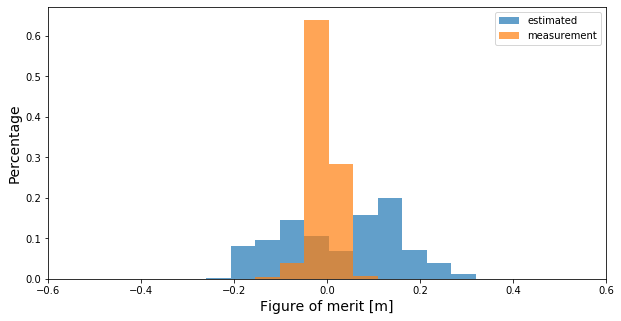

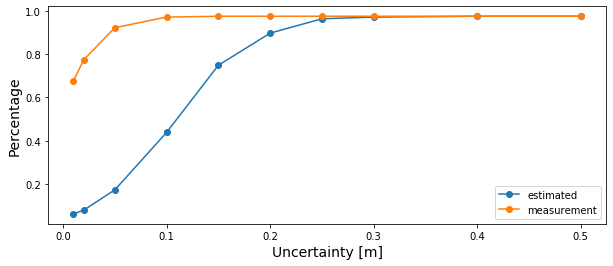

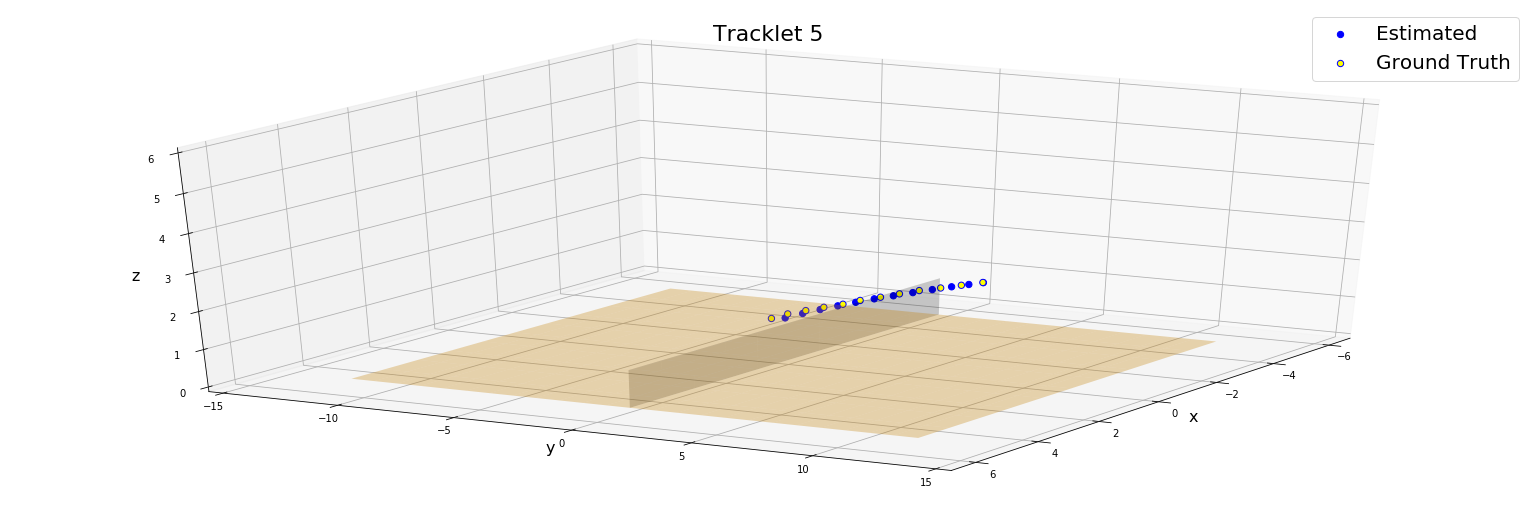

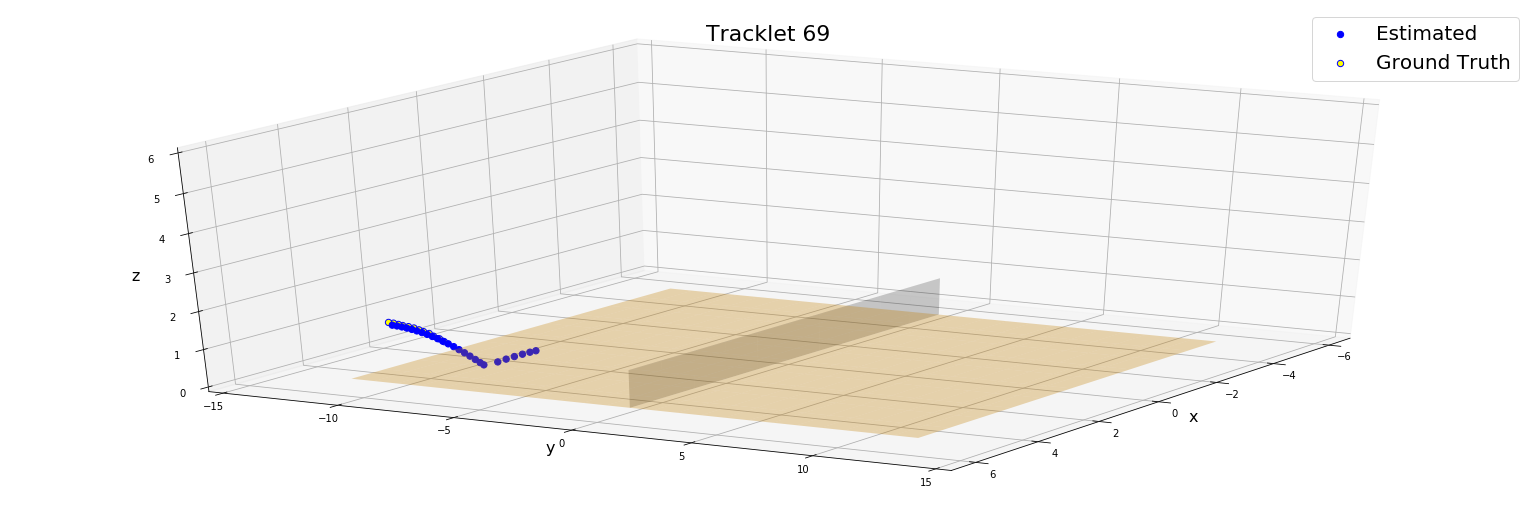

In [25]:
# Recover comparable points
a, mask, b = np.intersect1d(estimated[:,0], matching_gt[:,0], return_indices=True)
comparable = estimated[mask,:]
tot_pts = comparable.shape[0]

fig_merit = np.zeros(tot_pts)
for i in range(3):
    fig_merit += (matching_gt[:,i+1] - comparable[:,i+1])

fig_merit *= 1/3

fig=plt.figure(1,figsize=(10,5))
counts, nbins = np.histogram(fig_merit, bins='auto')
_ = plt.hist(fig_merit, nbins, weights=np.ones(len(fig_merit)) / len(fig_merit), \
             histtype='stepfilled', alpha=0.7, label='estimated')

# strange = comparable[fig_merit<-0.5, :]
# print(np.unique(strange[:,5]))

fig_merit_meas = np.zeros(comparable.shape[0])
for i in range(3):
    fig_merit_meas += (matching_gt[:,i+1] - matching_ball[:,i+1])

fig_merit_meas *= 1/3

#fig=plt.figure(2,figsize=(15,6))
counts, _, _ = plt.hist(fig_merit_meas, nbins, \
                        weights=np.ones(len(fig_merit_meas)) / len(fig_merit_meas), \
                        histtype='stepfilled', alpha=0.7, label='measurement')

# plt.title("Figure of merit", fontsize=22)
plt.legend()
plt.xlim([-0.6, 0.6])
plt.xlabel('Figure of merit [m]', fontsize=14)
plt.ylabel('Percentage', fontsize=14)

intervals = [0.01, 0.02, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.40, 0.50]
perc = np.zeros(len(intervals))
for i, thresh in enumerate(intervals):
    perc[i] = fig_merit[(fig_merit>-thresh) & (fig_merit<thresh)].shape[0] / tot_pts
#print(perc)

perc_meas = np.zeros(len(intervals))
for i, thresh in enumerate(intervals):
    perc_meas[i] = fig_merit_meas[(fig_merit_meas>-thresh) & (fig_merit_meas<thresh)].shape[0] / tot_pts
#print(perc_meas)

fig=plt.figure(2,figsize=(10,4))
plt.plot(intervals,perc, marker='o', label='estimated')
plt.plot(intervals,perc_meas, marker='o', label='measurement')
plt.legend()
plt.xlabel('Uncertainty [m]', fontsize=14)
plt.ylabel('Percentage', fontsize=14)

# Qualitative results

track_ID = 5

#meas = subtracklets_final[subtracklets_final[:,5] == track_ID]
track_gt = matching_gt[matching_gt[:,5] == track_ID]
estim = estimated[estimated[:,5] == track_ID]
plot_track(estim,'Estimated', track_gt,'Ground Truth', title='Tracklet {}'.format(track_ID))

track_ID = 69

# meas = subtracklets_final[subtracklets_final[:,5] == track_ID]
track_gt = matching_gt[matching_gt[:,5] == track_ID]
estim = estimated[estimated[:,5] == track_ID]
plot_track(estim,'Estimated', track_gt,'Ground Truth', title='Tracklet {}'.format(track_ID))

### Kalman smoothing results

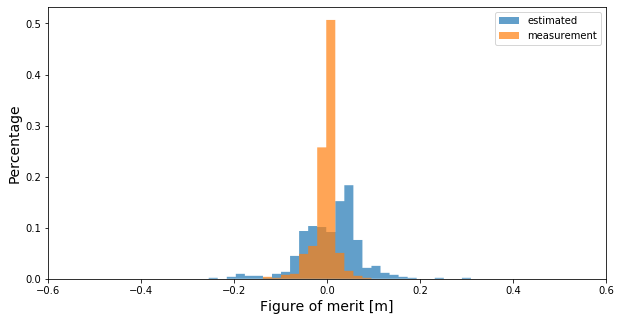

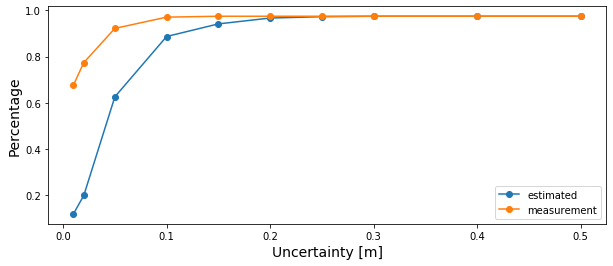

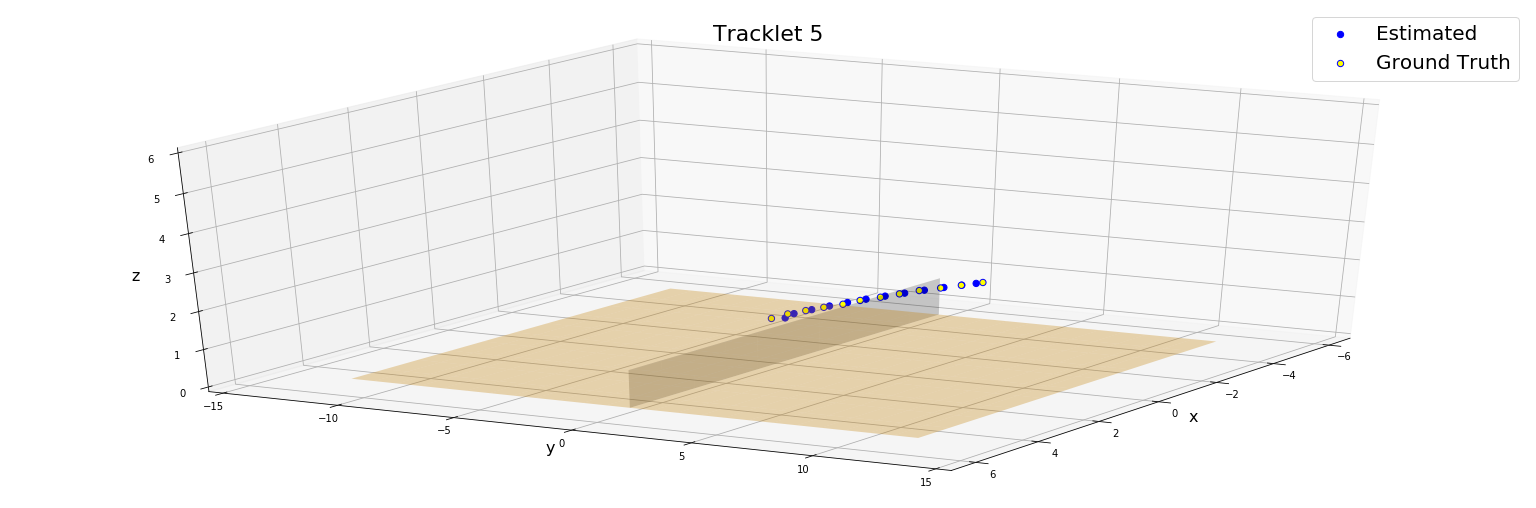

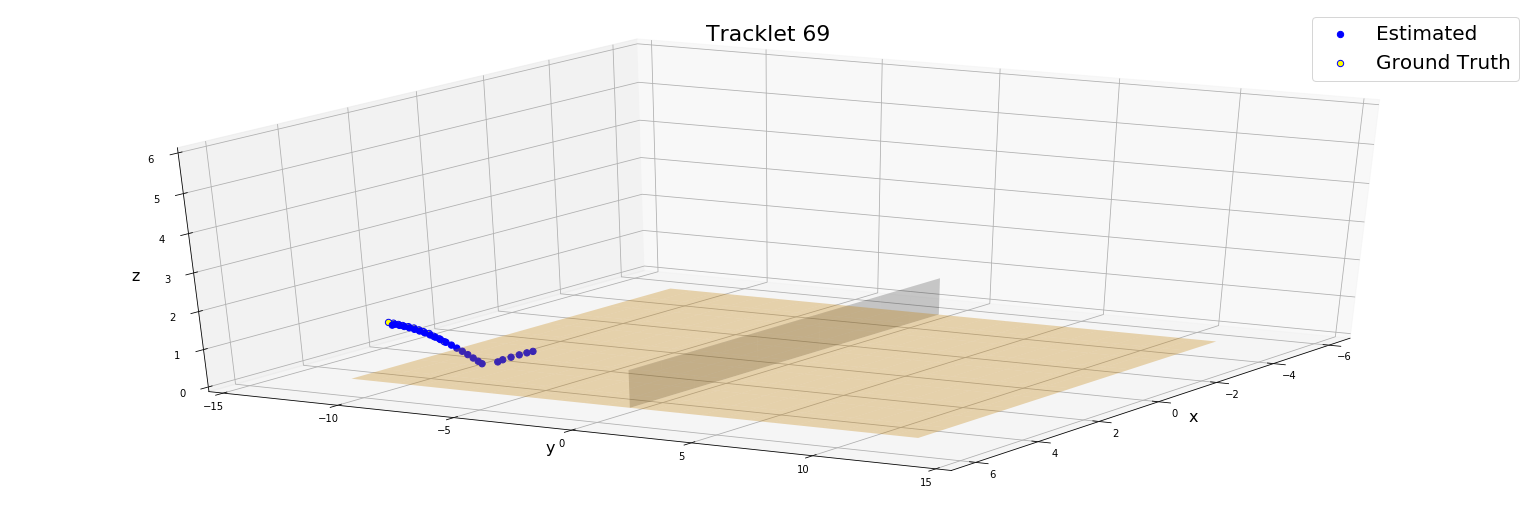

In [26]:
# Recover comparable points
a, mask, b = np.intersect1d(smoothed[:,0], matching_gt[:,0], return_indices=True)
comparable = smoothed[mask,:]
tot_pts = comparable.shape[0]

fig_merit = np.zeros(tot_pts)
for i in range(3):
    fig_merit += (matching_gt[:,i+1] - comparable[:,i+1])

fig_merit *= 1/3

fig=plt.figure(1,figsize=(10,5))
counts, nbins = np.histogram(fig_merit, bins='auto')
_ = plt.hist(fig_merit, nbins, weights=np.ones(len(fig_merit)) / len(fig_merit), \
             histtype='stepfilled', alpha=0.7, label='estimated')

# strange = comparable[fig_merit<-0.5, :]
# print(np.unique(strange[:,5]))

fig_merit_meas = np.zeros(comparable.shape[0])
for i in range(3):
    fig_merit_meas += (matching_gt[:,i+1] - matching_ball[:,i+1])

fig_merit_meas *= 1/3

#fig=plt.figure(2,figsize=(15,6))
counts, _, _ = plt.hist(fig_merit_meas, nbins, \
                        weights=np.ones(len(fig_merit_meas)) / len(fig_merit_meas), \
                        histtype='stepfilled', alpha=0.7, label='measurement')

# plt.title("Figure of merit", fontsize=22)
plt.legend()
plt.xlim([-0.6, 0.6])
plt.xlabel('Figure of merit [m]', fontsize=14)
plt.ylabel('Percentage', fontsize=14)


intervals = [0.01, 0.02, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.40, 0.50]
perc = np.zeros(len(intervals))
for i, thresh in enumerate(intervals):
    perc[i] = fig_merit[(fig_merit>-thresh) & (fig_merit<thresh)].shape[0] / tot_pts
#print(perc)

perc_meas = np.zeros(len(intervals))
for i, thresh in enumerate(intervals):
    perc_meas[i] = fig_merit_meas[(fig_merit_meas>-thresh) & (fig_merit_meas<thresh)].shape[0] / tot_pts
#print(perc_meas)

fig=plt.figure(2,figsize=(10,4))
plt.plot(intervals,perc, marker='o', label='estimated')
plt.plot(intervals,perc_meas, marker='o', label='measurement')
plt.legend()
plt.xlabel('Uncertainty [m]', fontsize=14)
plt.ylabel('Percentage', fontsize=14)

# Qualitative results

track_ID = 5

#meas = subtracklets_final[subtracklets_final[:,5] == track_ID]
track_gt = matching_gt[matching_gt[:,5] == track_ID]
estim = smoothed[smoothed[:,5] == track_ID]
plot_track(estim,'Estimated', track_gt,'Ground Truth', title='Tracklet {}'.format(track_ID))

track_ID = 69

meas = subtracklets_final[subtracklets_final[:,5] == track_ID]
track_gt = matching_gt[matching_gt[:,5] == track_ID]
estim = smoothed[smoothed[:,5] == track_ID]
plot_track(estim,'Estimated', track_gt,'Ground Truth', title='Tracklet {}'.format(track_ID))

In [27]:
# # Residuals
# x_mean = np.mean((matching_gt[:,1] - comparable[:,1]))
# y_mean = np.mean((matching_gt[:,2] - comparable[:,2]))
# z_mean = np.mean((matching_gt[:,3] - comparable[:,3]))
# x_var = np.var((matching_gt[:,1] - comparable[:,1]))
# y_var = np.var((matching_gt[:,2] - comparable[:,2]))
# z_var = np.var((matching_gt[:,3] - comparable[:,3]))

# # Residuals
# x_mean = np.mean((matching_gt[:,1] - comparable[:,1]))
# y_mean = np.mean((matching_gt[:,2] - comparable[:,2]))
# z_mean = np.mean((matching_gt[:,3] - comparable[:,3]))
# x_var = np.var((matching_gt[:,1] - comparable[:,1]))
# y_var = np.var((matching_gt[:,2] - comparable[:,2]))
# z_var = np.var((matching_gt[:,3] - comparable[:,3]))

# print("Residuals for Estimated points -------")
# print("Mean:")
# print(x_mean)
# print(y_mean)
# print(z_mean)
# print('\n')
# print("Variance:")
# print(x_var)
# print(y_var)
# print(z_var)
# print('\n')

# x_mean = np.mean((matching_gt[:,1] - matching_ball[:,1]))
# y_mean = np.mean((matching_gt[:,2] - matching_ball[:,2]))
# z_mean = np.mean((matching_gt[:,3] - matching_ball[:,3]))
# x_var = np.var((matching_gt[:,1] - matching_ball[:,1]))
# y_var = np.var((matching_gt[:,2] - matching_ball[:,2]))
# z_var = np.var((matching_gt[:,3] - matching_ball[:,3]))

# print("Residuals for Measurement points --------")
# print("Mean:")
# print(x_mean)
# print(y_mean)
# print(z_mean)
# print('\n')
# print("Variance:")
# print(x_var)
# print(y_var)
# print(z_var)
# print('\n')


## Experiment n. 2

Increment values in $Q$ to verify what happens to accuracy

In [36]:
newQ = Q.copy()*4

In [40]:
IDs = np.unique(subtracklets_final[:,5])

estimated = np.array([]).reshape(0,7)
smoothed = np.array([]).reshape(0,7)

for track_ID in IDs:
    
    current_track = subtracklets_final[subtracklets_final[:,5] == track_ID]
    
    sub_IDs = np.unique(current_track[:,6])
    
    for sub_ID in sub_IDs:
        
        current_subtrack = current_track[current_track[:,6] == sub_ID]
        
        # Get the full frame interval covered by the current subtracklet
        full_frames = np.arange(current_subtrack[0,0].astype('int'), current_subtrack[-1,0].astype('int')+1)
        length = full_frames.shape[0]

        # Create an augmented subtrack (generate a row for missing frame)
        augmented_subtrack = full_frames.copy()[:,None]
        augmented_subtrack = np.concatenate((augmented_subtrack, np.zeros((length,3)), \
                                             np.ones(length)[:,None], track_ID*np.ones(length)[:,None], \
                                            sub_ID*np.ones(length)[:,None]), axis=1)

        # Insert original meas and keep row with x,y,z = (0,0,0) for missing frames
        a, idx_orig, idx_new = np.intersect1d(current_subtrack[:,0], augmented_subtrack[:,0], return_indices=True)
        augmented_subtrack[idx_new,1:4] = current_subtrack[idx_orig,1:4]

        
        # Define input for Kalman
        
        meas = augmented_subtrack[:,1:4].T

        x0 = np.concatenate((meas[:,0][:,None], (meas[:,1] - meas[:,0])[:,None]), axis=0) 
        P0 = newQ

        # Our measurement vector is made of (x,y,z) positions of our subtracklet
        # (including missing frames)
        # Kalman filter is modified in order to deal with missing frames
        z = meas[:,1:]

        T = z.shape[1]  # number of meas
        u = np.zeros((n, T))
        u[2,:] = g*np.ones(T)

        # Run Kalman filter
        x_filtered, P_forward, z_filtered = kalman_filter(z, x0, P0, u, Phi, B, newQ, H, R)
        
        # Store the result
        meas[:,1:] = z_filtered
        estimated = np.concatenate((estimated, augmented_subtrack), axis=0)
        
        
        # Run Kalman smoothing
        x_smoothed, P_backward, z_smoothed = kalman_smoothing(x0, P0, x_filtered, P_forward, u, Phi, B, newQ, H, R)
        
        meas[:,:-1] = z_smoothed
        smoothed = np.concatenate((smoothed, augmented_subtrack), axis=0)

###  Kalman algorithm results

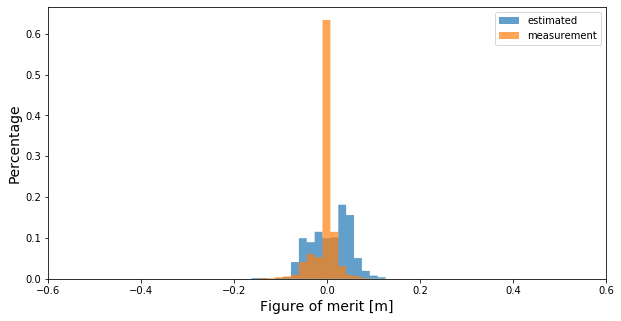

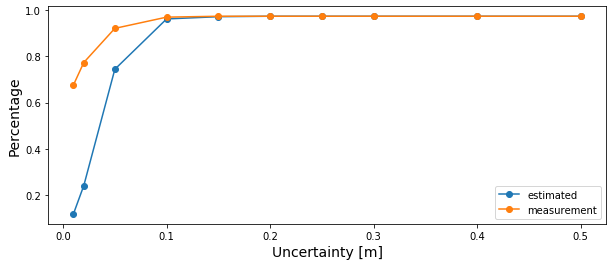

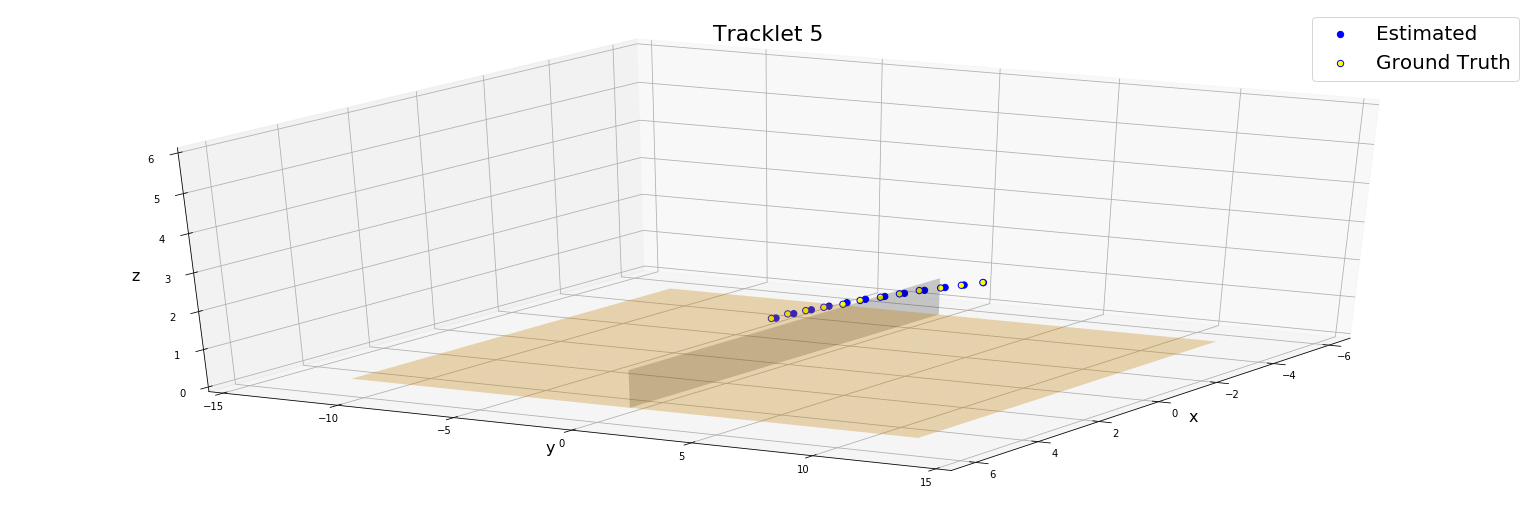

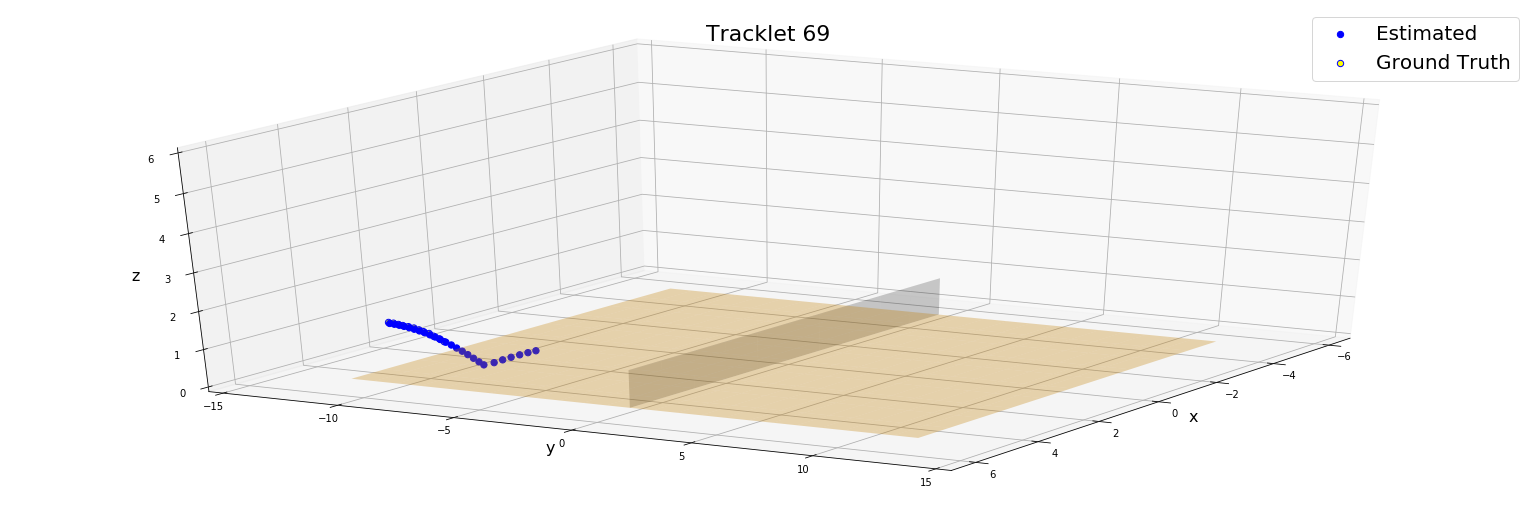

In [38]:
# Recover comparable points
a, mask, b = np.intersect1d(estimated[:,0], matching_gt[:,0], return_indices=True)
comparable = estimated[mask,:]
tot_pts = comparable.shape[0]

fig_merit = np.zeros(tot_pts)
for i in range(3):
    fig_merit += (matching_gt[:,i+1] - comparable[:,i+1])

fig_merit *= 1/3

fig=plt.figure(1,figsize=(10,5))
counts, nbins = np.histogram(fig_merit, bins='auto')
_ = plt.hist(fig_merit, nbins, weights=np.ones(len(fig_merit)) / len(fig_merit), \
             histtype='stepfilled', alpha=0.7, label='estimated')

# strange = comparable[fig_merit<-0.5, :]
# print(np.unique(strange[:,5]))

fig_merit_meas = np.zeros(comparable.shape[0])
for i in range(3):
    fig_merit_meas += (matching_gt[:,i+1] - matching_ball[:,i+1])

fig_merit_meas *= 1/3

#fig=plt.figure(2,figsize=(15,6))
counts, _, _ = plt.hist(fig_merit_meas, nbins, \
                        weights=np.ones(len(fig_merit_meas)) / len(fig_merit_meas), \
                        histtype='stepfilled', alpha=0.7, label='measurement')

# plt.title("Figure of merit", fontsize=22)
plt.legend()
plt.xlim([-0.6, 0.6])
plt.xlabel('Figure of merit [m]', fontsize=14)
plt.ylabel('Percentage', fontsize=14)

intervals = [0.01, 0.02, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.40, 0.50]
perc = np.zeros(len(intervals))
for i, thresh in enumerate(intervals):
    perc[i] = fig_merit[(fig_merit>-thresh) & (fig_merit<thresh)].shape[0] / tot_pts
#print(perc)

perc_meas = np.zeros(len(intervals))
for i, thresh in enumerate(intervals):
    perc_meas[i] = fig_merit_meas[(fig_merit_meas>-thresh) & (fig_merit_meas<thresh)].shape[0] / tot_pts
#print(perc_meas)

fig=plt.figure(2,figsize=(10,4))
plt.plot(intervals,perc, marker='o', label='estimated')
plt.plot(intervals,perc_meas, marker='o', label='measurement')
plt.legend()
plt.xlabel('Uncertainty [m]', fontsize=14)
plt.ylabel('Percentage', fontsize=14)

# Qualitative results

track_ID = 5

#meas = subtracklets_final[subtracklets_final[:,5] == track_ID]
track_gt = matching_gt[matching_gt[:,5] == track_ID]
estim = estimated[estimated[:,5] == track_ID]
plot_track(estim,'Estimated', track_gt,'Ground Truth', title='Tracklet {}'.format(track_ID))

track_ID = 69

# meas = subtracklets_final[subtracklets_final[:,5] == track_ID]
track_gt = matching_gt[matching_gt[:,5] == track_ID]
estim = estimated[estimated[:,5] == track_ID]
plot_track(estim,'Estimated', track_gt,'Ground Truth', title='Tracklet {}'.format(track_ID))

### Kalman smoothing results

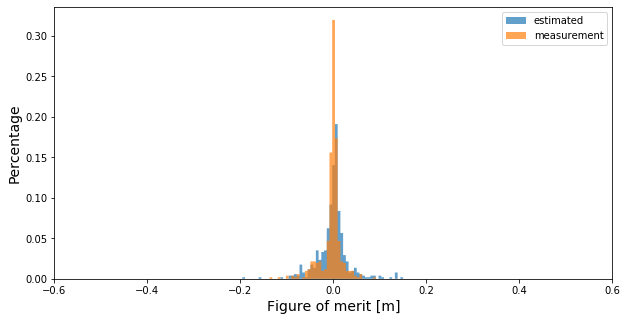

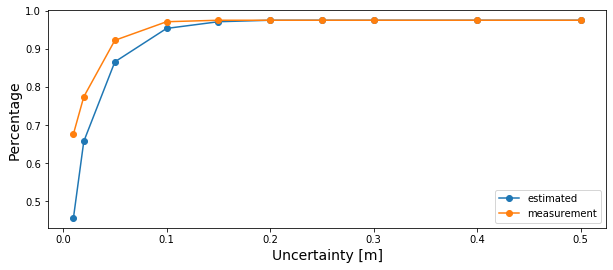

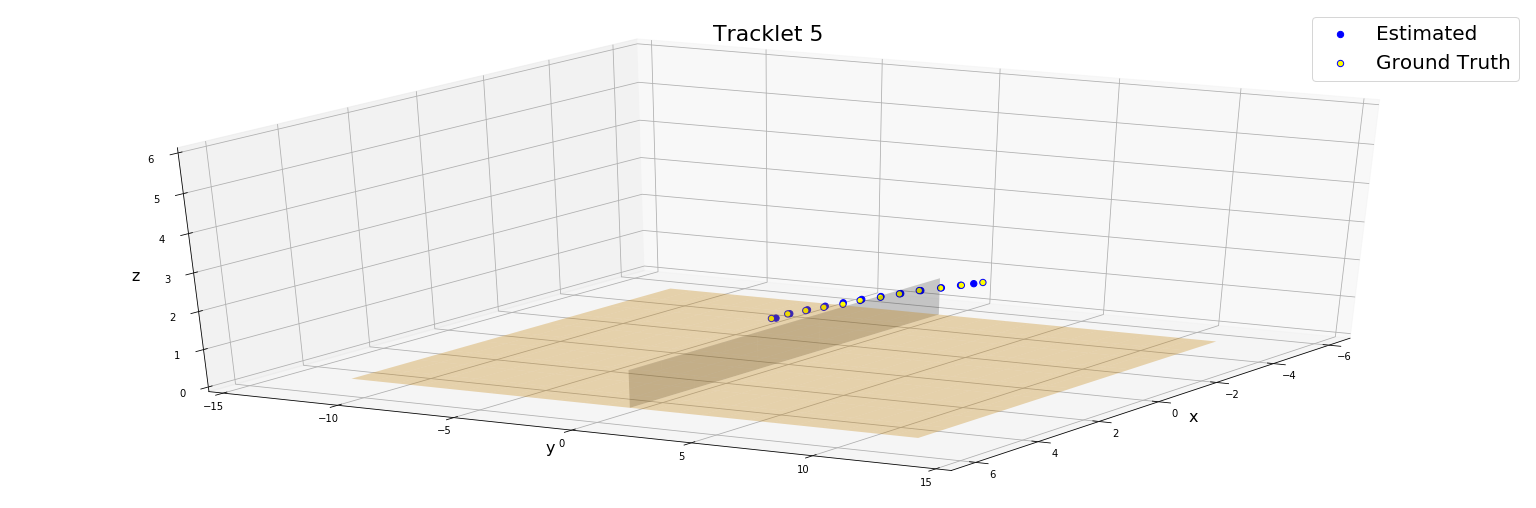

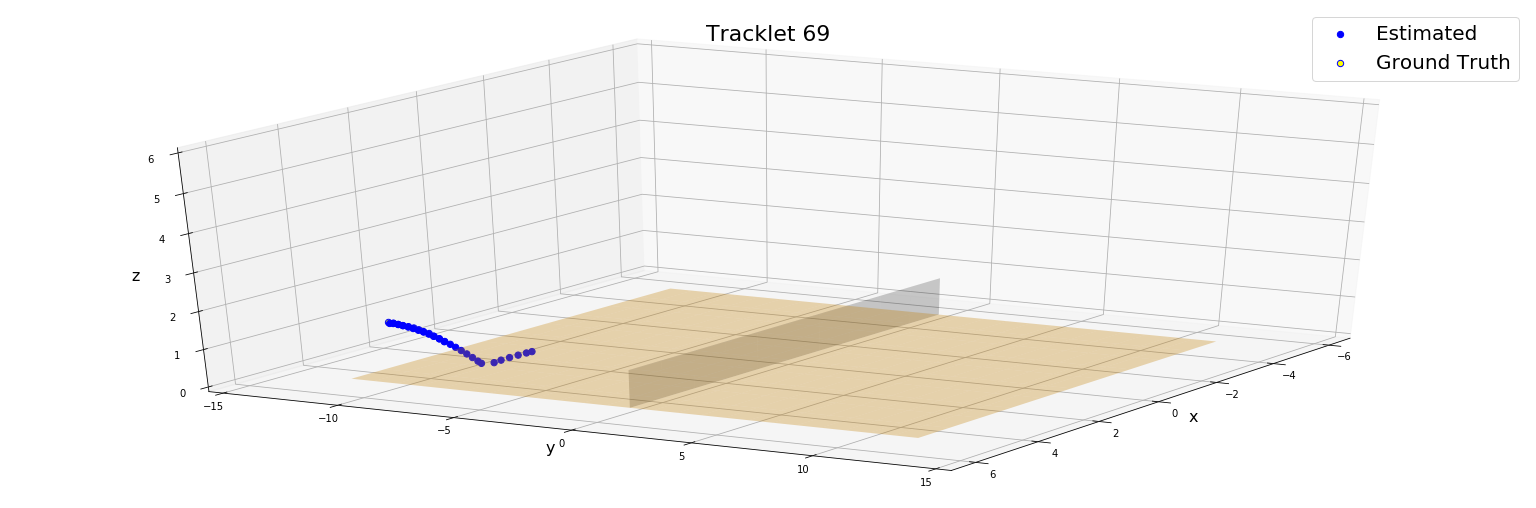

In [41]:
# Recover comparable points
a, mask, b = np.intersect1d(smoothed[:,0], matching_gt[:,0], return_indices=True)
comparable = smoothed[mask,:]
tot_pts = comparable.shape[0]

fig_merit = np.zeros(tot_pts)
for i in range(3):
    fig_merit += (matching_gt[:,i+1] - comparable[:,i+1])

fig_merit *= 1/3

fig=plt.figure(1,figsize=(10,5))
counts, nbins = np.histogram(fig_merit, bins='auto')
_ = plt.hist(fig_merit, nbins, weights=np.ones(len(fig_merit)) / len(fig_merit), \
             histtype='stepfilled', alpha=0.7, label='estimated')

# strange = comparable[fig_merit<-0.5, :]
# print(np.unique(strange[:,5]))

fig_merit_meas = np.zeros(comparable.shape[0])
for i in range(3):
    fig_merit_meas += (matching_gt[:,i+1] - matching_ball[:,i+1])

fig_merit_meas *= 1/3

#fig=plt.figure(2,figsize=(15,6))
counts, _, _ = plt.hist(fig_merit_meas, nbins, \
                        weights=np.ones(len(fig_merit_meas)) / len(fig_merit_meas), \
                        histtype='stepfilled', alpha=0.7, label='measurement')

# plt.title("Figure of merit", fontsize=22)
plt.legend()
plt.xlim([-0.6, 0.6])
plt.xlabel('Figure of merit [m]', fontsize=14)
plt.ylabel('Percentage', fontsize=14)


intervals = [0.01, 0.02, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.40, 0.50]
perc = np.zeros(len(intervals))
for i, thresh in enumerate(intervals):
    perc[i] = fig_merit[(fig_merit>-thresh) & (fig_merit<thresh)].shape[0] / tot_pts
#print(perc)

perc_meas = np.zeros(len(intervals))
for i, thresh in enumerate(intervals):
    perc_meas[i] = fig_merit_meas[(fig_merit_meas>-thresh) & (fig_merit_meas<thresh)].shape[0] / tot_pts
#print(perc_meas)

fig=plt.figure(2,figsize=(10,4))
plt.plot(intervals,perc, marker='o', label='estimated')
plt.plot(intervals,perc_meas, marker='o', label='measurement')
plt.legend()
plt.xlabel('Uncertainty [m]', fontsize=14)
plt.ylabel('Percentage', fontsize=14)

# Qualitative results

track_ID = 5

#meas = subtracklets_final[subtracklets_final[:,5] == track_ID]
track_gt = matching_gt[matching_gt[:,5] == track_ID]
estim = smoothed[smoothed[:,5] == track_ID]
plot_track(estim,'Estimated', track_gt,'Ground Truth', title='Tracklet {}'.format(track_ID))

track_ID = 69

meas = subtracklets_final[subtracklets_final[:,5] == track_ID]
track_gt = matching_gt[matching_gt[:,5] == track_ID]
estim = smoothed[smoothed[:,5] == track_ID]
plot_track(estim,'Estimated', track_gt,'Ground Truth', title='Tracklet {}'.format(track_ID))

## Experiment n.3

Increase values in $R$ to see how accuracy is affected.

In [32]:
newR = R.copy() * 16

In [33]:
IDs = np.unique(subtracklets_final[:,5])

estimated = np.array([]).reshape(0,7)
smoothed = np.array([]).reshape(0,7)

for track_ID in IDs:
    
    current_track = subtracklets_final[subtracklets_final[:,5] == track_ID]
    
    sub_IDs = np.unique(current_track[:,6])
    
    for sub_ID in sub_IDs:
        
        current_subtrack = current_track[current_track[:,6] == sub_ID]
        
        # Get the full frame interval covered by the current subtracklet
        full_frames = np.arange(current_subtrack[0,0].astype('int'), current_subtrack[-1,0].astype('int')+1)
        length = full_frames.shape[0]

        # Create an augmented subtrack (generate a row for missing frame)
        augmented_subtrack = full_frames.copy()[:,None]
        augmented_subtrack = np.concatenate((augmented_subtrack, np.zeros((length,3)), \
                                             np.ones(length)[:,None], track_ID*np.ones(length)[:,None], \
                                            sub_ID*np.ones(length)[:,None]), axis=1)

        # Insert original meas and keep row with x,y,z = (0,0,0) for missing frames
        a, idx_orig, idx_new = np.intersect1d(current_subtrack[:,0], augmented_subtrack[:,0], return_indices=True)
        augmented_subtrack[idx_new,1:4] = current_subtrack[idx_orig,1:4]

        
        # Define input for Kalman
        
        meas = augmented_subtrack[:,1:4].T

        x0 = np.concatenate((meas[:,0][:,None], (meas[:,1] - meas[:,0])[:,None]), axis=0) 
        P0 = Q

        # Our measurement vector is made of (x,y,z) positions of our subtracklet
        # (including missing frames)
        # Kalman filter is modified in order to deal with missing frames
        z = meas[:,1:]

        T = z.shape[1]  # number of meas
        u = np.zeros((n, T))
        u[2,:] = g*np.ones(T)

        # Run Kalman filter
        x_filtered, P_forward, z_filtered = kalman_filter(z, x0, P0, u, Phi, B, Q, H, newR)
        
        # Store the result
        meas[:,1:] = z_filtered
        estimated = np.concatenate((estimated, augmented_subtrack), axis=0)
        
        
        # Run Kalman smoothing
        x_smoothed, P_backward, z_smoothed = kalman_smoothing(x0, P0, x_filtered, P_forward, u, Phi, B, Q, H, newR)
        
        meas[:,:-1] = z_smoothed
        smoothed = np.concatenate((smoothed, augmented_subtrack), axis=0)

### Kalman filter result

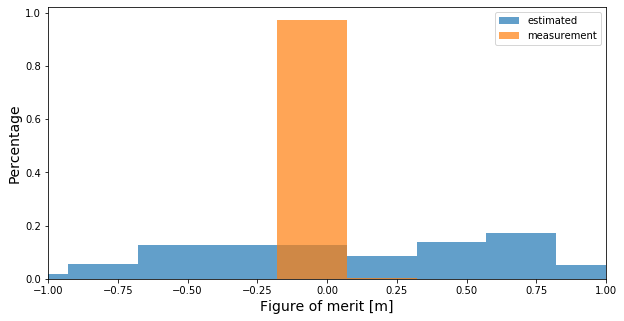

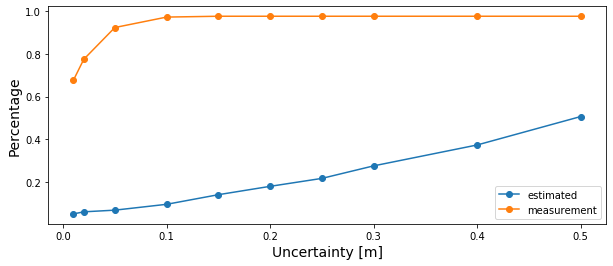

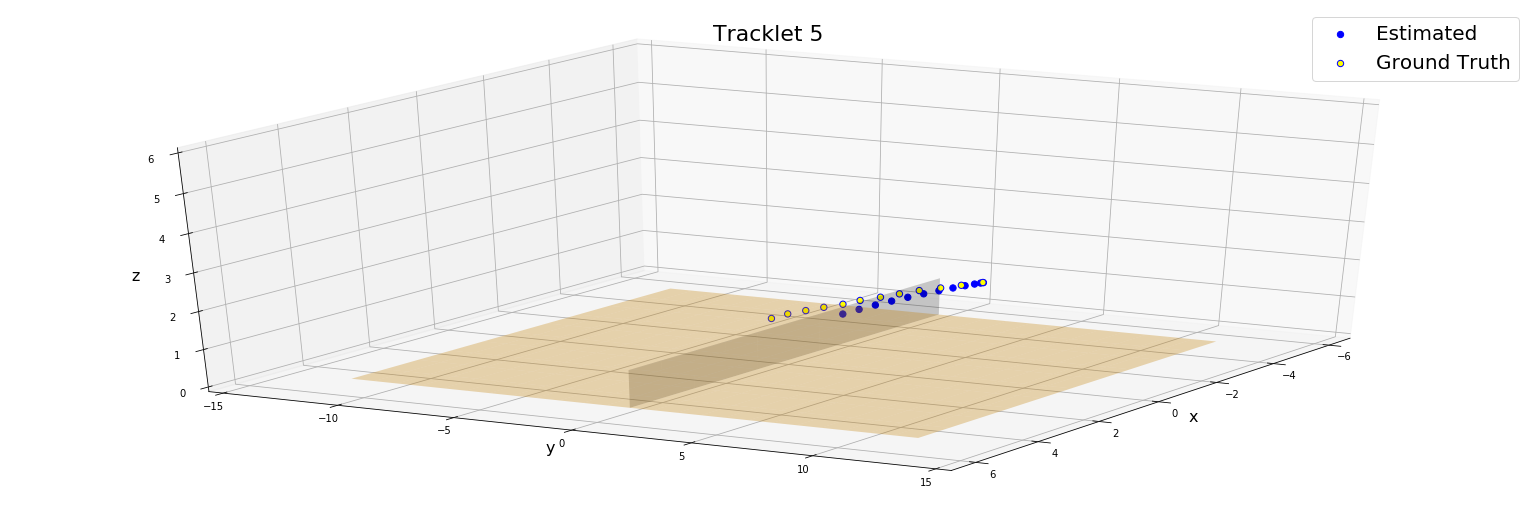

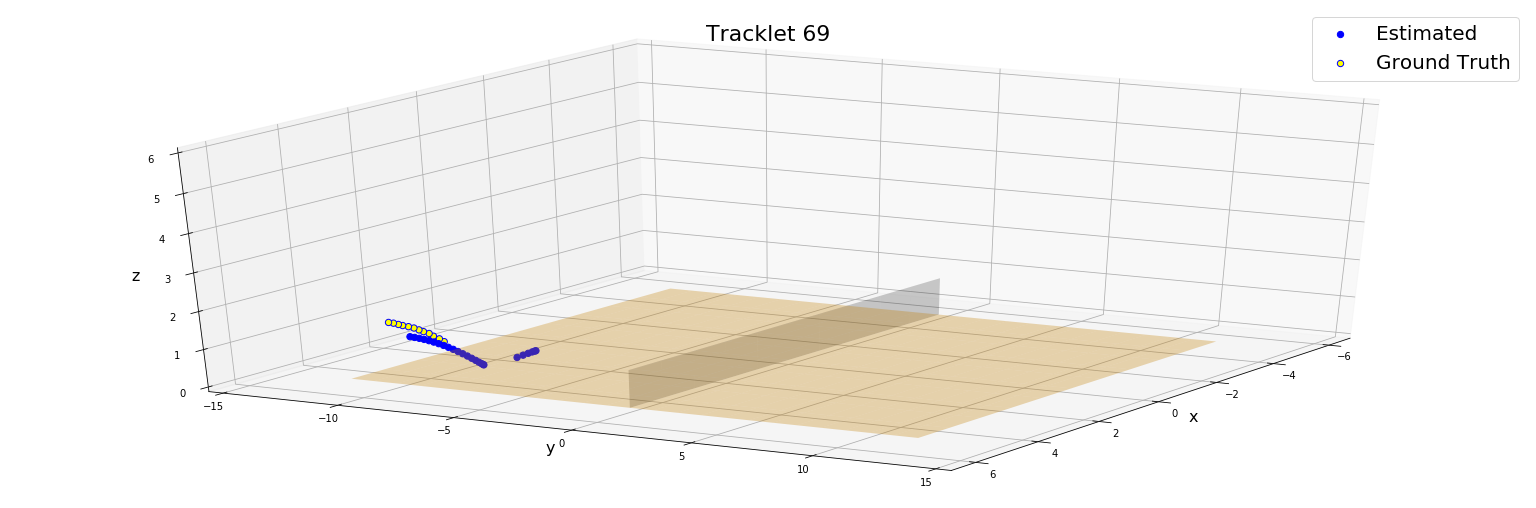

In [34]:
# Recover comparable points
a, mask, b = np.intersect1d(estimated[:,0], matching_gt[:,0], return_indices=True)
comparable = estimated[mask,:]
tot_pts = comparable.shape[0]

fig_merit = np.zeros(tot_pts)
for i in range(3):
    fig_merit += (matching_gt[:,i+1] - comparable[:,i+1])

fig_merit *= 1/3

fig=plt.figure(1,figsize=(10,5))
counts, nbins = np.histogram(fig_merit, bins='auto')
_ = plt.hist(fig_merit, nbins, weights=np.ones(len(fig_merit)) / len(fig_merit), \
             histtype='stepfilled', alpha=0.7, label='estimated')

# strange = comparable[fig_merit<-0.5, :]
# print(np.unique(strange[:,5]))

fig_merit_meas = np.zeros(comparable.shape[0])
for i in range(3):
    fig_merit_meas += (matching_gt[:,i+1] - matching_ball[:,i+1])

fig_merit_meas *= 1/3

#fig=plt.figure(2,figsize=(15,6))
counts, _, _ = plt.hist(fig_merit_meas, nbins, \
                        weights=np.ones(len(fig_merit_meas)) / len(fig_merit_meas), \
                        histtype='stepfilled', alpha=0.7, label='measurement')

# plt.title("Figure of merit", fontsize=22)
plt.legend()
plt.xlim([-1, 1])
plt.xlabel('Figure of merit [m]', fontsize=14)
plt.ylabel('Percentage', fontsize=14)

intervals = [0.01, 0.02, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.40, 0.50]
perc = np.zeros(len(intervals))
for i, thresh in enumerate(intervals):
    perc[i] = fig_merit[(fig_merit>-thresh) & (fig_merit<thresh)].shape[0] / tot_pts
#print(perc)

perc_meas = np.zeros(len(intervals))
for i, thresh in enumerate(intervals):
    perc_meas[i] = fig_merit_meas[(fig_merit_meas>-thresh) & (fig_merit_meas<thresh)].shape[0] / tot_pts
#print(perc_meas)

fig=plt.figure(2,figsize=(10,4))
plt.plot(intervals,perc, marker='o', label='estimated')
plt.plot(intervals,perc_meas, marker='o', label='measurement')
plt.legend()
plt.xlabel('Uncertainty [m]', fontsize=14)
plt.ylabel('Percentage', fontsize=14)

# Qualitative results

track_ID = 5

#meas = subtracklets_final[subtracklets_final[:,5] == track_ID]
track_gt = matching_gt[matching_gt[:,5] == track_ID]
estim = estimated[estimated[:,5] == track_ID]
plot_track(estim,'Estimated', track_gt,'Ground Truth', title='Tracklet {}'.format(track_ID))

track_ID = 69

# meas = subtracklets_final[subtracklets_final[:,5] == track_ID]
track_gt = matching_gt[matching_gt[:,5] == track_ID]
estim = estimated[estimated[:,5] == track_ID]
plot_track(estim,'Estimated', track_gt,'Ground Truth', title='Tracklet {}'.format(track_ID))

### Kalman smoothing results

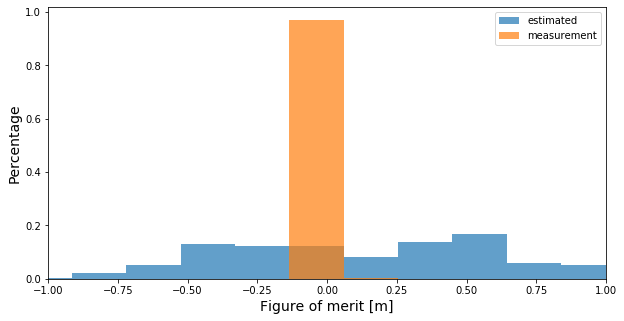

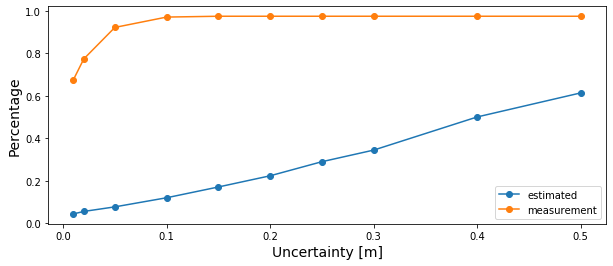

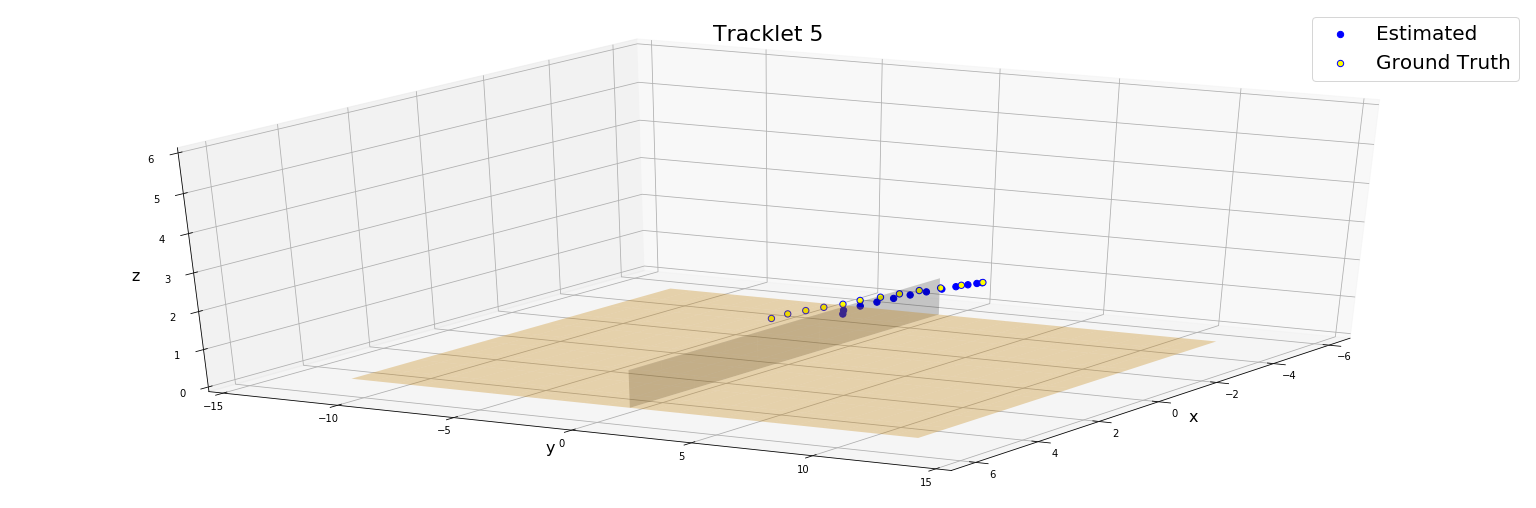

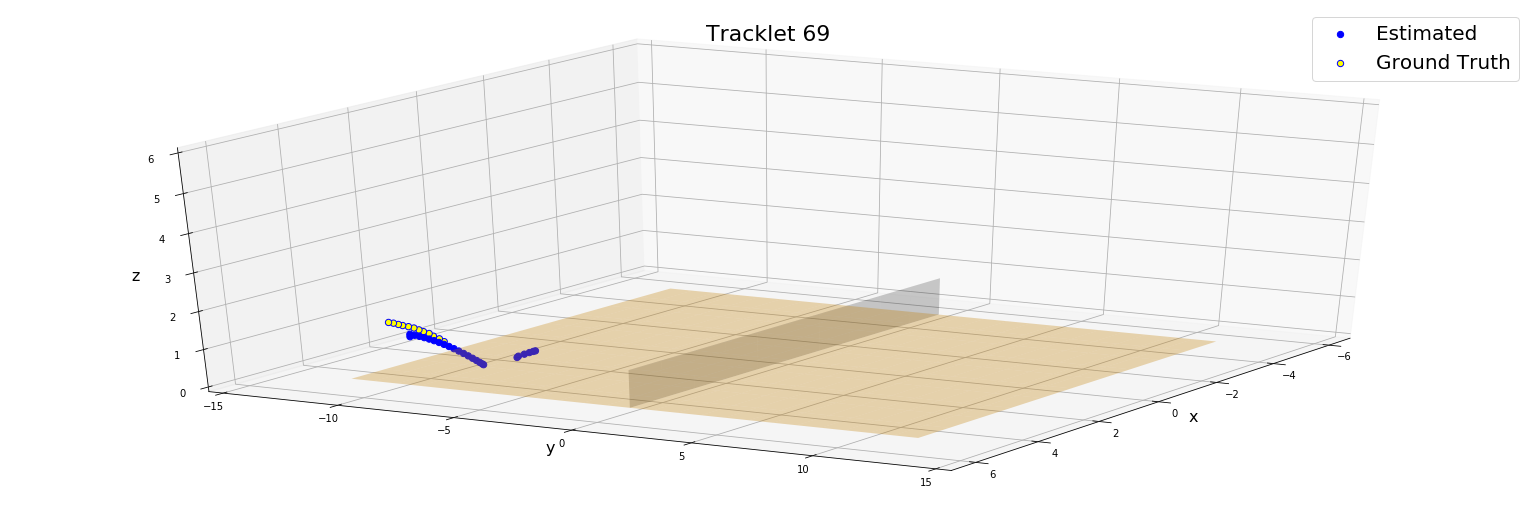

In [35]:
# Recover comparable points
a, mask, b = np.intersect1d(smoothed[:,0], matching_gt[:,0], return_indices=True)
comparable = smoothed[mask,:]
tot_pts = comparable.shape[0]

fig_merit = np.zeros(tot_pts)
for i in range(3):
    fig_merit += (matching_gt[:,i+1] - comparable[:,i+1])

fig_merit *= 1/3

fig=plt.figure(1,figsize=(10,5))
counts, nbins = np.histogram(fig_merit, bins='auto')
_ = plt.hist(fig_merit, nbins, weights=np.ones(len(fig_merit)) / len(fig_merit), \
             histtype='stepfilled', alpha=0.7, label='estimated')

# strange = comparable[fig_merit<-0.5, :]
# print(np.unique(strange[:,5]))

fig_merit_meas = np.zeros(comparable.shape[0])
for i in range(3):
    fig_merit_meas += (matching_gt[:,i+1] - matching_ball[:,i+1])

fig_merit_meas *= 1/3

#fig=plt.figure(2,figsize=(15,6))
counts, _, _ = plt.hist(fig_merit_meas, nbins, \
                        weights=np.ones(len(fig_merit_meas)) / len(fig_merit_meas), \
                        histtype='stepfilled', alpha=0.7, label='measurement')

# plt.title("Figure of merit", fontsize=22)
plt.legend()
plt.xlim([-1, 1])
plt.xlabel('Figure of merit [m]', fontsize=14)
plt.ylabel('Percentage', fontsize=14)


intervals = [0.01, 0.02, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.40, 0.50]
perc = np.zeros(len(intervals))
for i, thresh in enumerate(intervals):
    perc[i] = fig_merit[(fig_merit>-thresh) & (fig_merit<thresh)].shape[0] / tot_pts
#print(perc)

perc_meas = np.zeros(len(intervals))
for i, thresh in enumerate(intervals):
    perc_meas[i] = fig_merit_meas[(fig_merit_meas>-thresh) & (fig_merit_meas<thresh)].shape[0] / tot_pts
#print(perc_meas)

fig=plt.figure(2,figsize=(10,4))
plt.plot(intervals,perc, marker='o', label='estimated')
plt.plot(intervals,perc_meas, marker='o', label='measurement')
plt.legend()
plt.xlabel('Uncertainty [m]', fontsize=14)
plt.ylabel('Percentage', fontsize=14)

# Qualitative results

track_ID = 5

#meas = subtracklets_final[subtracklets_final[:,5] == track_ID]
track_gt = matching_gt[matching_gt[:,5] == track_ID]
estim = smoothed[smoothed[:,5] == track_ID]
plot_track(estim,'Estimated', track_gt,'Ground Truth', title='Tracklet {}'.format(track_ID))

track_ID = 69

meas = subtracklets_final[subtracklets_final[:,5] == track_ID]
track_gt = matching_gt[matching_gt[:,5] == track_ID]
estim = smoothed[smoothed[:,5] == track_ID]
plot_track(estim,'Estimated', track_gt,'Ground Truth', title='Tracklet {}'.format(track_ID))

## Conclusion

The linear physical model assumed as process model appears too simple to obtain a reasonable accuracy. The measurements themselves reveal to be more trustfully in this case for the state estimation.